**Note:** There may be some discrepancies between the model outputs and text summaries as new data will be added periodically to the models using the streamlit app feedback

**The Impact of Strength Metrics on Climbing Performance**

In recent years companies such as Lattice and Power Climbing Company have begun using data analytics to inform climbers of where their potential weaknesses are in order to better personalise training plans (and hopefully improve long term performance).

Many of these datasets are not publicly available, but the team at Power Company Climbing have been kind enough to share theirs.

In this notebook I am using a dataset from Power Company Climbing which contains around 600 self reported members, providing a variety of climbing benchmarks. The goal of the workbook is to test different machine learning models to determine which metrics play the largest role in climbing performance, and whether we can use this data to then predict max bouldering and sport climbing grades.

The workbook splits out bouldering and sport climbing and performs the analysis on these two variations of climbing separately. This is because bouldering and sport climbing are very different disciplines, even though they are both a form of climbing.

![Burden of dreams](https://cdn.climbing.com/wp-content/uploads/2023/04/DSC01953-scaled.jpg?crop=535:301&width=1070&enable=upscale)

The dataset contains the following variables:

'age',

'sex',

'max_boulder', - Max grade of boulder on the V scale climbed in the last year

'max_sport', - Max sport climbing grade climbed in the last year 

'exp', - years bouldering

'trainexp', - years specifically training for bouldering

'country',

'state',

'rock', - Rock type climbed on

'season', - Months per year spent climbing outside

'days', - Days per month spent climbing outside

'height',

'weight',

'span', - Wing span

'pullup',

'pushup',

'continuous', - Continuous hang from a 20mm edge

'maxhang', - Max weight added to hang for 10 seconds from a 20mm edge

'weightedpull', - Max weight added for single pull up

'repeaters1', - 7:3 hang:recovery on a 20mm edge

'longcamp', - long campus, unclear what rungs

'shortcamp', - short campus, unclear what rungs

**Final Results**

The models have produced different results for climbing vs bouldering, which was expected, indicating that it's more important to be stronger in specific areas if you want to sport climb or boulder.

For bouldering, the most important metrics were:

1. strength_to_weight_maxhang: the maximum weight you can add to your hang on a 20mm edge for 10 seconds
2. strength_to_weight_pullup: the number of pullups you can do at bodyweight
3. strength_to_weight_weightpull: the number of pullups you can do, with your max weight added on
4. days climbing outside: how many days you spend climbing outside each month/year

This seems like a reasonable outcome given the raw strength and power needed for bouldering in the upper grades, with spending time outside also being an important factors. It's generally common knowledge that time spent climbing outside can significantly contritube to getting stronger and climbing harder grades. This might also account for the fact that more time spent outside means more time for projecting routes.

For sport climbing, the results are quite different: 

1. days climbing outside: how many days you spend climbing outside each month/year
2. repeaters: repeaters are 7s on, 3s recovery on a 20mm edge
3. continuous: how long you can hang from a 20mm edge
4. strength_to_weight_weightpull: The number of pullups you can do, with your max weight added on

Again these results seems like a reasonable outcome given that sport climbing requires a lot of endurance when climbing hard grades, and the longer you spend climbing outside the more likely it is that you can project harder routes. 


So, in summary:

If you want to boulder hard, make good use of the fingerboard and max hang training, including lots of weighted and non-weighted pullups (think explosive pulls with a band etc)
If you want to sport climb hard, improve your endurance on the 20mm edge, and do lots of weighted pullups.

And most importantly for both sport and bouldering - make sure you get ouside and climb some real rock!

![bibliographie](https://www.patagonia.com/blog/wp-content/uploads/2020/11/etzel_k_1399_cc_web-1280x720-1.jpg)

In [115]:
# import all requires libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import shap
import mlflow
import pickle
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import pymongo
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

warnings.filterwarnings('ignore')

In [116]:
# read the data file using pandas, specifying the encoding
original_data = pd.read_csv(r'/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/PowerCompanyAssessmentData.csv',encoding="cp1252")

# display the first few rows of the dataframe to check everything is in order
print(original_data.columns)

# drop the "country", "state", and "rock" columns from the dataframe, as they will not be used in the analysis
data = original_data.drop(columns=["country", "state", "rock"])
print(data.columns)  # print the dataframe again to confirm the columns have been dropped

Index(['age', 'sex', 'max_boulder', 'max_sport', 'exp', 'trainexp', 'country',
       'state', 'rock', 'season', 'days', 'height', 'weight', 'span', 'pullup',
       'pushup', 'continuous', 'maxhang', 'weightedpull', 'repeaters1',
       'longcamp', 'shortcamp', 'ohpr', 'ohll', 'dl', 'bmi_score'],
      dtype='object')
Index(['age', 'sex', 'max_boulder', 'max_sport', 'exp', 'trainexp', 'season',
       'days', 'height', 'weight', 'span', 'pullup', 'pushup', 'continuous',
       'maxhang', 'weightedpull', 'repeaters1', 'longcamp', 'shortcamp',
       'ohpr', 'ohll', 'dl', 'bmi_score'],
      dtype='object')


In [117]:
# check the total number of rows and columns in the DataFrame
total_rows, total_columns = data.shape

# print the values of each
print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 679
Total number of columns: 23


In [118]:
# transform variables from the imperial to the metric system
data['height'] = data['height'] * 2.54  # convert inches to centimeters
data['weight'] = data['weight'] * 0.45359237  # convert pounds to kilograms
data['ohpr'] = data['ohpr'] * 0.45359237  # convert pounds to kilograms
data['ohll'] = data['ohll'] * 0.45359237  # convert pounds to kilograms
data['dl'] = data['dl'] * 0.45359237  # convert pounds to kilograms
data['span'] = data['span'] * 2.54  # convert inches to centimeters
data['weightedpull'] = data['weightedpull'] * 0.45359237  # convert pounds to kilograms
data['maxhang'] = data['maxhang'] * 0.45359237  # convert pounds to kilograms

# create new variables representing strength-to-weight ratios for different physical activities
#data['strength_to_weight_pullup'] = (data['pullup'] + data['bmi_score'])/ data['bmi_score']
#data['strength_to_weight_weightpull'] = (data['weightedpull'] + data['bmi_score']) / data['bmi_score']
#data['strength_to_weight_maxhang'] = (data['maxhang'] + data['bmi_score']) / data['bmi_score']
data['strength_to_weight_pullup'] = data['pullup'] / data['weight']
data['strength_to_weight_weightpull'] = (data['weightedpull'] + data['weight']) / data['weight']
data['strength_to_weight_maxhang'] = (data['maxhang'] + data['weight']) / data['weight']

# coerce any errors during conversion of 'continuous' column to a numeric type to NaN
data['continuous'] = pd.to_numeric(data['continuous'], errors='coerce')

In [119]:
print(data["sex"].value_counts())

sex
Male                          490
Female                        182
0                               3
Other/Prefer to Not Answer      3
Other                           1
Name: count, dtype: int64


In [120]:
# create dictionaries to map experience, season, and days climbing to numeric values so we can use these if needed in our models
experience_dict = { "< 1 year":1,"<1 year":1,"1-2 years":2,"3-4 years":3,"5-6 years":4,"7-8 years":5,
                   "9-10 years":6, ">10 years":7, "> 10 years":8}
season_dict = {"1-3 months":1,"4-6 months":2,"7-9 months":3,"Year round":4}
days_dict = {'3-4 days per month':3, '5-6 days per month':4, '1-5 days per month':5,
       '7-8 days per month':6, '>10 days per month':7, '>15 days per month':8,
             '9-10 days per month':9, 'I currently do no climb outdoors':1, '15-20':10,}
sex_dict = {'Male':1, 'Female':2, 'Other/Prefer to Not Answer':3,'Other':3,'0':3, 'NaN':3}

In [121]:
# apply the dictionaries to the respective columns
data["exp"] = data["exp"].map(experience_dict)
data["sex"] = data["sex"].map(sex_dict)
data["trainexp"] = data["trainexp"].map(experience_dict)
data["season"] = data["season"].map(season_dict)
data['days'] = data['days'].replace(days_dict)
data['days'] = pd.to_numeric(data['days'])
# Convert 'days' from per year to per month for entries from index 37 onwards as historically users inputed their climbing days like this
data["days"][37:] = data["days"][37:]/12

In [122]:
# show distribution of values for all columns which had dictionaries applied
print(data["sex"].value_counts())


sex
1    490
2    182
3      7
Name: count, dtype: int64


In [123]:
# define a function to convert YDS to French grade for sport climbing
def convert_to_french_grade(grade):
    # create a map of YDS grades to French grades
    conversion_map = {
        "<5.10": "4c",
        "5.10": "5a", "5.10a": "5b", "5.10b": "5b/5c",
        "5.10c": "5c", "5.10d": "5c/6a", "5.11a": "6a",
        "5.11b": "6a+", "5.11c": "6b", "5.11d": "6b+",
        "5.12a": "6c", "5.12b": "6c+", "5.12c": "7a",
        "5.12d": "7a+", "5.13a": "7b", "5.13b": "7b+",
        "5.13c": "7c", "5.13d": "7c+", "5.14a": "8a",
        "5.14b": "8a+", "5.14c": "8b", "5.14d": "8b+",
        "5.15a": "8c", "5.15b": "8c+", "5.15c": "9a",
        "5.15d": "9a+", "I have not pursued sport climbing goals outside in the past year": "0"
    }

    if pd.isnull(grade):  # check if the grade is null
        return np.nan  # return NaN if grade is null

    if "/" in grade:  # check if grade is a range
        # if grade is a range like "5.12a/b", split and use the higher grade
        grade_a, grade_b = grade.split("/")
        grade = grade_a

    if grade in conversion_map:  # check if grade is in the conversion map
        return conversion_map[grade]  # convert the grade to French grade
    else:
        raise ValueError(f'Unexpected grade value: {grade}') 

# convert French grades to numerical values
conversion_map_french = {
    '4c': 1, '5a': 2, '5b': 3, '5c': 4, '6a': 5,
    '6a+': 6, '6b': 7, '6b+': 8, '6c': 9, '6c+': 10, '7a': 11,
    '7a+': 12, '7b': 13, '7b+': 14, '7c': 15, '7c+': 16, '8a': 17,
    '8a+': 18, '8b': 19, '8b+': 20, '8c': 21, '8c+': 22, '9a': 23, '9a+': 24, '0': 0
}

# apply the conversion function to create a new column of French grades
try:
    data['max_sport_french'] = data['max_sport'].apply(convert_to_french_grade)
except ValueError as e:
    print(e)  

# map the French grades to numerical values
data['max_sport_numeric'] = data['max_sport_french'].map(conversion_map_french)

In [124]:
# define a function to convert V Grade bouldering to numeric
def convert_v_grade_to_numeric(grade):
    # map of V grades to numerical values
    conversion_map = {
        "<V3": 1,
        "V3": 2, "V4": 3, "V5": 4,
        "V6": 5, "V7": 6, "V8": 7,
        "V9": 8, "V10": 9, "V11": 10,
        "V12": 11, "V13": 12, "V14": 13,
        "V15": 14, "V16": 15, "I have not pursued bouldering goals outside in the past year": 0
    }

    if grade in conversion_map:  # check if the grade is in the conversion map
        return conversion_map[grade]  # convert the grade to numeric
    else:
        return np.nan  # return NaN for unknown or unclassifiable grades

# apply the conversion function to the 'max_boulder' column to create a new column of numeric V grades
data['max_boulder_numeric'] = data['max_boulder'].apply(convert_v_grade_to_numeric)

In the two sections above I have converted the YDS and V grades to numeric values, again to help with analysis later on. I have also gone one step further with the sport climbing grades and converted from the YDS to French grade. Below I've created a reverse mapping in order to convert the numeric output of the models back in to V grades and French sport grades.

In [125]:
# function to convert numerical grade back to french sport grade so that users can easily understand their results
# reverse the conversion_map dictionary to map from numerical grade back to French grade sport
inverse_conversion_map_f = {v: k for k, v in conversion_map_french.items()}

# now define a function to convert numeric grade to V grade
def convert_numeric_to_f_grade(numeric_grade):
    numeric_grade = round(numeric_grade)

    if numeric_grade in inverse_conversion_map_f:
        return inverse_conversion_map_f[numeric_grade]
    else:
        return "Unknown grade" 

In [126]:
# function to convert numerical grade back to V grade so that users can easily understand their results
# reverse the conversion_map dictionary to map from numerical grade back to V bouldering grade
conversion_map_boulder = {
    "<V3": 1,
    "V3": 2, "V4": 3, "V5": 4,
    "V6": 5, "V7": 6, "V8": 7,
    "V9": 8, "V10": 9, "V11": 10,
    "V12": 11, "V13": 12, "V14": 13,
    "V15": 14, "V16": 15, "I have not pursued bouldering goals outside in the past year": 0
}

# reverse the conversion_map dictionary to map from numerical grade back to V grade
inverse_conversion_map_v = {v: k for k, v in conversion_map_boulder.items()}

# function to convert numeric grade to V grade
def convert_numeric_to_v_grade(numeric_grade):
    numeric_grade = round(numeric_grade)

    if numeric_grade in inverse_conversion_map_v:
        return inverse_conversion_map_v[numeric_grade]
    else:
        return "Unknown grade" 

In [127]:
# display the first few rows of the dataframe to check the new columns
print(data.head())

   age  sex max_boulder max_sport  exp  trainexp  season  days  height  \
0   43    2         <V3   5.10c/d  7.0       1.0     3.0   3.0  165.10   
1   16    2          V6   5.12c/d  5.0       5.0     2.0   4.0  162.56   
2   19    1          V9   5.13c/d  7.0       5.0     2.0   5.0  177.80   
3   34    1          V8   5.12a/b  7.0       4.0     2.0   6.0  172.72   
4   30    2          V8   5.12a/b  5.0       3.0     2.0   4.0  172.72   

      weight  ...       ohpr       ohll         dl  bmi_score  \
0  68.492448  ...        NaN        NaN        NaN       25.1   
1  56.699046  ...   6.803886   6.803886  49.895161       21.5   
2  70.306817  ...        NaN        NaN        NaN       22.2   
3  74.842741  ...        NaN        NaN        NaN       25.1   
4  64.410117  ...  11.339809  11.339809  65.770894       21.6   

   strength_to_weight_pullup  strength_to_weight_weightpull  \
0                   0.029200                       1.066225   
1                   0.264555          

In [128]:
# display all the column names and their data type
print(data.columns)

Index(['age', 'sex', 'max_boulder', 'max_sport', 'exp', 'trainexp', 'season',
       'days', 'height', 'weight', 'span', 'pullup', 'pushup', 'continuous',
       'maxhang', 'weightedpull', 'repeaters1', 'longcamp', 'shortcamp',
       'ohpr', 'ohll', 'dl', 'bmi_score', 'strength_to_weight_pullup',
       'strength_to_weight_weightpull', 'strength_to_weight_maxhang',
       'max_sport_french', 'max_sport_numeric', 'max_boulder_numeric'],
      dtype='object')


In [129]:
# get an idea of the spread of sport climbing grades
count_max_sport = data['max_sport'].value_counts()
print(count_max_sport)

max_sport
I have not pursued sport climbing goals outside in the past year    170
5.12a/b                                                             150
5.12c/d                                                              91
5.13a/b                                                              82
5.11c/d                                                              47
5.11a/b                                                              42
5.13c/d                                                              38
5.10c/d                                                              21
5.14a/b                                                              14
5.10a/b                                                              14
<5.10                                                                 3
5.14c/d                                                               1
Name: count, dtype: int64


In [130]:
# get an idea of the spread of bouldering grades
count_max_boulder = data['max_boulder'].value_counts()
print(count_max_boulder)

max_boulder
I have not pursued bouldering goals outside in the past year    149
V8                                                               88
V7                                                               85
V5                                                               78
V6                                                               62
V10                                                              59
V9                                                               48
V4                                                               39
<V3                                                              31
V11                                                              16
V12                                                              10
V13                                                               6
V15                                                               2
V14                                                               2
Name: count, dtype: int64


Total rows:
679

Percentage of zeroes:
pushup                        0.147275
span                          0.294551
continuous                    0.441826
ohpr                          0.589102
ohll                          0.589102
days                          0.736377
shortcamp                     1.030928
pullup                        1.178203
longcamp                      1.178203
strength_to_weight_pullup     1.178203
repeaters1                    1.472754
dl                            1.620029
weightedpull                  1.767305
maxhang                       3.240059
max_boulder_numeric          21.944035
max_sport_numeric            25.036819
dtype: float64

Counts of NaNs:
weight                             1
trainexp                           2
max_boulder                        4
height                             4
max_boulder_numeric                4
exp                                4
max_sport                          6
max_sport_french                   6
max_sport

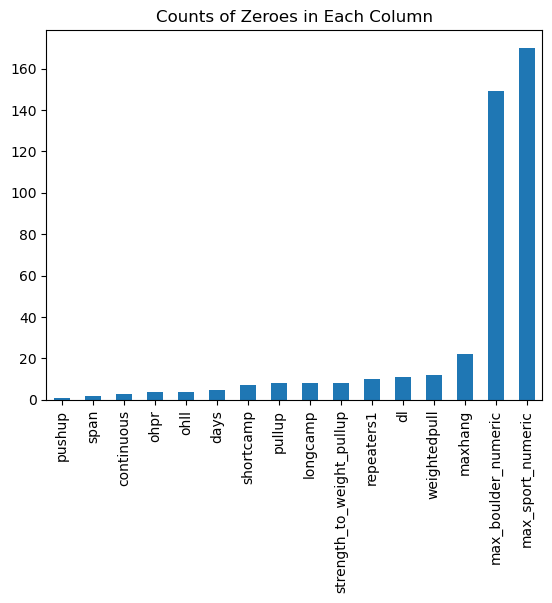

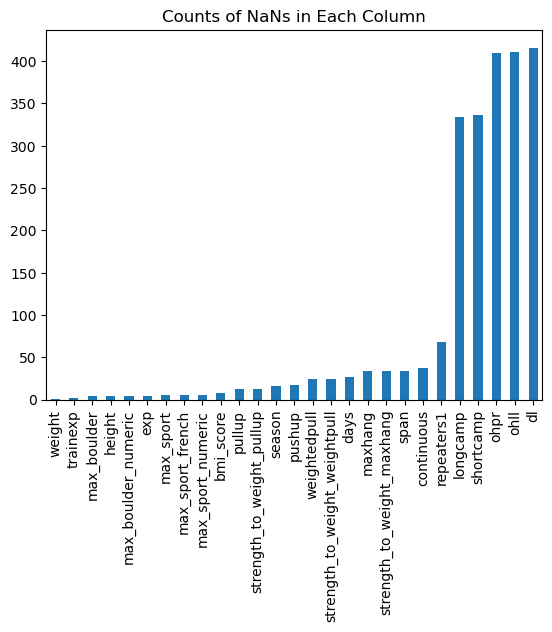

In [131]:
# count zero values and filter columns with more than 0 zeroes
zero_counts = (data == 0).sum()
zero_counts = zero_counts[zero_counts > 0]
zero_counts.sort_values(inplace=True)

# calculate percentage of total values that are zero for each column
total_rows = len(data)
zero_percentage = (zero_counts / total_rows) * 100

nan_counts = data.isnull().sum()
nan_counts = nan_counts[nan_counts > 0]
nan_counts.sort_values(inplace=True)

# print and plot
print("Total rows:")
print(total_rows)
print("\nPercentage of zeroes:")
print(zero_percentage)
print("\nCounts of NaNs:")
print(nan_counts)

# create bar plot for zero counts
zero_counts.plot.bar()
plt.title('Counts of Zeroes in Each Column')
plt.show()

# create bar plot for nan counts
nan_counts.plot.bar()
plt.title('Counts of NaNs in Each Column')
plt.show()


In [132]:
# now that we have our new numeric columns we can remove all non-numeric columns
data.drop(['max_boulder', 'max_sport','max_sport_french'], axis=1, inplace=True)
data.head()

,age,sex,exp,trainexp,season,days,height,weight,span,pullup,...,shortcamp,ohpr,ohll,dl,bmi_score,strength_to_weight_pullup,strength_to_weight_weightpull,strength_to_weight_maxhang,max_sport_numeric,max_boulder_numeric
0,43,2,7.0,1.0,3.0,3.0,165.10,68.492448,165.10,2.0,...,62.0,NaN,NaN,NaN,25.1,0.029200,1.066225,1.245033,4.0,1.0
1,16,2,5.0,5.0,2.0,4.0,162.56,56.699046,162.56,15.0,...,NaN,6.803886,6.803886,49.895161,21.5,0.264555,1.160000,1.080000,11.0,5.0
2,19,1,7.0,5.0,2.0,5.0,177.80,70.306817,187.96,18.0,...,301.0,NaN,NaN,NaN,22.2,0.256021,1.548387,1.225806,15.0,8.0
3,34,1,7.0,4.0,2.0,6.0,172.72,74.842741,182.88,15.0,...,NaN,NaN,NaN,NaN,25.1,0.200420,1.424242,1.303030,9.0,7.0
4,30,2,5.0,3.0,2.0,4.0,172.72,64.410117,177.80,5.0,...,210.0,11.339809,11.339809,65.770894,21.6,0.077628,1.176056,1.246479,9.0,7.0


In [133]:
# Use KNNImputer to impute missing values, specifically the 0s
knn_imputer = KNNImputer(n_neighbors=5) 
# store column names before imputation
column_names = data.columns
# perform imputation
data_imputed = knn_imputer.fit_transform(data)
# convert the result back to a DataFrame
data_imputed_df = pd.DataFrame(data_imputed, columns=column_names)

K-Nearest Neighbors (KNN) is a versatile algorithm that can be used for both classification and regression tasks, including imputation of missing values. When KNN is used for imputation, the basic idea is to fill in a missing value for a given data point with the value of the nearest neighbor(s). KNN imputation can be particularly effective when the data has an underlying structure that can be captured with the distance metric, meaning that points that are close in the feature space have similar target values. 

I have made an assumption here that strength metrics which are close together predict similar max sport and bouldering grades.

In [134]:
data_imputed_df.head()

,age,sex,exp,trainexp,season,days,height,weight,span,pullup,...,shortcamp,ohpr,ohll,dl,bmi_score,strength_to_weight_pullup,strength_to_weight_weightpull,strength_to_weight_maxhang,max_sport_numeric,max_boulder_numeric
0,43.0,2.0,7.0,1.0,3.0,3.0,165.10,68.492448,165.10,2.0,...,62.000,11.339809,10.886217,67.675982,25.1,0.029200,1.066225,1.245033,4.0,1.0
1,16.0,2.0,5.0,5.0,2.0,4.0,162.56,56.699046,162.56,15.0,...,95.276,6.803886,6.803886,49.895161,21.5,0.264555,1.160000,1.080000,11.0,5.0
2,19.0,1.0,7.0,5.0,2.0,5.0,177.80,70.306817,187.96,18.0,...,301.000,22.498182,22.498182,127.368737,22.2,0.256021,1.548387,1.225806,15.0,8.0
3,34.0,1.0,7.0,4.0,2.0,6.0,172.72,74.842741,182.88,15.0,...,117.200,21.863152,21.863152,111.402286,25.1,0.200420,1.424242,1.303030,9.0,7.0
4,30.0,2.0,5.0,3.0,2.0,4.0,172.72,64.410117,177.80,5.0,...,210.000,11.339809,11.339809,65.770894,21.6,0.077628,1.176056,1.246479,9.0,7.0


In [135]:
data = data_imputed_df.copy()

In [136]:
# save the data df to a csv file
data.to_csv(r'/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/data_imputed.csv')

In [137]:
# we've replaced all 0 values with a KNN. Now lets drop all NAs in the max_boulder_numeric column
# create a new df for bouldering specifically - after some testing, if we kept both sport and bouldering and removed NAs, we would be dropping a lot of rows and keeping only around 150/200 rows of data
data_clean_bouldering = data.dropna(subset=['max_boulder_numeric'])
# drop rows where 'max_boulder_numeric' is 0. This shouldn't actually drop any rows but run it in order to make sure our data is clean
data_clean_bouldering = data_clean_bouldering[(data_clean_bouldering['max_boulder_numeric'] != 0)]

In [138]:
# To check the total number of rows and columns in the bouldering df
total_rows, total_columns = data_clean_bouldering.shape

total_rows = len(data_clean_bouldering)

print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 530
Total number of columns: 26


In [139]:
# we've replaced all 0 values with a KNN. Now lets drop all NAs in the max_sport_numeric column
# create a new df for sport specifically - if we kept both sport and bouldering and removed NAs, we would be dropping a lot of rows
data_clean_sport = data.dropna(subset=['max_sport_numeric'])

# drop rows where 'max_sport_numeric' is 0. This shouldn't actually drop any rows but run it in order to make sure our data is clean
data_clean_sport = data_clean_sport[(data_clean_sport['max_sport_numeric'] != 0)]

In [140]:
# check the total number of rows and columns in the sport df
total_rows, total_columns = data_clean_sport.shape

total_rows = len(data_clean_sport)

print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 509
Total number of columns: 26


In [141]:
# explore the  descriptive statistics of the bouldering df to identify if we have outliers
data_clean_bouldering.describe()

,age,sex,exp,trainexp,season,days,height,weight,span,pullup,...,shortcamp,ohpr,ohll,dl,bmi_score,strength_to_weight_pullup,strength_to_weight_weightpull,strength_to_weight_maxhang,max_sport_numeric,max_boulder_numeric
count,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,...,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000
mean,32.711321,1.275472,5.176604,2.951321,2.667170,4.348899,174.539598,69.151381,177.518491,15.096226,...,144.715053,20.478925,20.060131,110.526596,22.682755,0.221091,1.485271,1.401572,7.081132,6.095094
std,7.261368,0.471857,1.722458,1.636391,0.966518,4.294815,14.583032,10.385107,35.481506,6.248807,...,78.930692,5.331486,5.376404,33.896963,2.523551,0.092314,0.198980,0.208009,5.261666,2.484769
min,16.000000,1.000000,1.000000,1.000000,1.000000,0.166667,144.780000,43.091275,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.500000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,28.000000,1.000000,4.000000,2.000000,2.000000,2.083333,167.640000,62.142155,170.180000,11.000000,...,90.000000,17.327229,16.646840,92.986436,21.400000,0.164955,1.355952,1.251375,0.000000,4.000000
50%,31.000000,1.000000,5.000000,3.000000,3.000000,3.650000,175.260000,69.399633,177.800000,15.000000,...,130.200000,21.273482,20.411657,112.717704,22.650000,0.209964,1.480822,1.399387,9.000000,6.000000
75%,37.000000,2.000000,7.000000,4.000000,4.000000,5.354167,180.340000,76.090120,185.420000,18.000000,...,182.900000,24.040396,23.677522,132.131457,23.900000,0.265113,1.617647,1.533333,11.000000,8.000000
max,60.000000,3.000000,8.000000,8.000000,4.000000,75.000000,406.400000,130.634603,482.600000,50.000000,...,662.000000,37.194574,37.194574,272.155422,41.300000,0.615816,2.666667,2.564516,19.000000,14.000000


In [142]:
# explore the  descriptive statistics of the sport df to identify if we have outliers
data_clean_sport.describe()

,age,sex,exp,trainexp,season,days,height,weight,span,pullup,...,shortcamp,ohpr,ohll,dl,bmi_score,strength_to_weight_pullup,strength_to_weight_weightpull,strength_to_weight_maxhang,max_sport_numeric,max_boulder_numeric
count,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,...,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000
mean,33.952849,1.300589,5.322200,2.966994,2.712377,4.429404,174.357167,69.280602,178.864954,14.559528,...,154.527544,20.603253,20.180904,108.665226,22.701139,0.212557,1.451846,1.358318,9.740668,4.354420
std,8.288222,0.488066,1.735207,1.630326,0.968776,4.296594,10.313485,10.198258,39.121463,6.969710,...,91.529717,5.283656,5.351604,33.054655,2.380624,0.102482,0.196777,0.197292,3.398033,3.250846
min,16.000000,1.000000,1.000000,1.000000,1.000000,0.000000,147.320000,43.091275,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,8.700000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,28.000000,1.000000,4.000000,2.000000,2.000000,2.500000,167.640000,62.595747,170.180000,10.000000,...,95.000000,16.692199,16.329325,84.005307,21.340000,0.153486,1.325203,1.225806,7.000000,1.000000
50%,32.000000,1.000000,6.000000,3.000000,3.000000,3.666667,175.260000,69.853225,177.800000,14.000000,...,142.000000,21.228123,20.774531,110.676538,22.600000,0.201730,1.454545,1.352000,9.000000,5.000000
75%,39.000000,2.000000,7.000000,4.000000,4.000000,5.550000,180.340000,75.749926,185.420000,18.000000,...,190.000000,24.040396,23.586803,129.273825,23.900000,0.258354,1.583333,1.486486,13.000000,7.000000
max,73.000000,3.000000,8.000000,8.000000,4.000000,75.000000,281.940000,130.634603,482.600000,68.000000,...,730.000000,40.823313,38.555351,272.155422,41.300000,1.063222,2.032895,2.081081,19.000000,14.000000


This below section is used for detecting and removing outliers in the dataset. It allows me to see what the median, min, and max values are to help decide which columns have significant outliers. In this case I am using z-score which is also known as a standard score. This is a numerical measurement that describes a value's relationship to the mean of a group of values. It is measured in terms of standard deviations from the mean. If a z-score is 0, it indicates that the data point's score is identical to the mean score.

In [143]:
# bouldering data
# columns for outlier removal based on 'min' and 'max' fields
cols_to_consider = ['height', 'weight', 'span']
# fill NaNs for Z-score calculation
data_clean_bouldering[cols_to_consider] = data_clean_bouldering[cols_to_consider].fillna(data_clean_bouldering[cols_to_consider].mean())
# calculate absolute Z-scores
abs_z_scores = np.abs(stats.zscore(data_clean_bouldering[cols_to_consider]))
# identify non-outliers (within 3 standard deviations)
non_outlier_mask = (abs_z_scores < 3).all(axis=1)
# remove outliers
data_clean_bouldering = data_clean_bouldering[non_outlier_mask]

# descriptive statistics after outlier removal to confirm outliers have been removed
data_clean_bouldering.describe()

,age,sex,exp,trainexp,season,days,height,weight,span,pullup,...,shortcamp,ohpr,ohll,dl,bmi_score,strength_to_weight_pullup,strength_to_weight_weightpull,strength_to_weight_maxhang,max_sport_numeric,max_boulder_numeric
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,...,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,32.603883,1.277670,5.166214,2.953786,2.669126,4.327346,173.877451,68.930125,177.225220,15.074563,...,143.925006,20.476657,20.065922,110.880347,22.677204,0.221353,1.487702,1.403259,7.050485,6.109515
std,7.190460,0.473609,1.725170,1.628241,0.962830,4.328169,9.383885,10.040010,11.449392,6.026894,...,76.816152,5.326705,5.332415,33.484867,2.150108,0.090726,0.199041,0.208196,5.250275,2.490723
min,16.000000,1.000000,1.000000,1.000000,1.000000,0.166667,144.780000,43.091275,145.796000,0.000000,...,0.000000,0.000000,0.000000,0.000000,12.800000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,28.000000,1.000000,4.000000,2.000000,2.000000,2.083333,167.640000,62.142155,170.180000,11.100000,...,90.100000,17.690102,16.873636,93.077154,21.400000,0.166150,1.356349,1.251441,0.000000,4.000000
50%,31.000000,1.000000,5.000000,3.000000,3.000000,3.333333,175.260000,69.399633,177.800000,15.000000,...,130.000000,21.228123,20.411657,112.944500,22.600000,0.209964,1.482759,1.400000,9.000000,6.000000
75%,37.000000,2.000000,7.000000,4.000000,4.000000,5.166667,180.340000,75.749926,185.420000,18.000000,...,182.500000,24.040396,23.677522,132.086098,23.800000,0.266170,1.618392,1.534409,11.000000,8.000000
max,60.000000,3.000000,8.000000,8.000000,4.000000,75.000000,195.580000,98.883137,246.786400,50.000000,...,662.000000,37.194574,37.194574,272.155422,34.000000,0.612395,2.666667,2.564516,19.000000,14.000000


In [144]:
# sport data
# columns for outlier removal based on 'min' and 'max' fields
cols_to_consider = ['height', 'weight', 'span']
# fill NaNs for Z-score calculation
data_clean_sport[cols_to_consider] = data_clean_sport[cols_to_consider].fillna(data_clean_sport[cols_to_consider].mean())
# calculate absolute Z-scores
abs_z_scores = np.abs(stats.zscore(data_clean_sport[cols_to_consider]))
# identify non-outliers (within 3 standard deviations)
non_outlier_mask = (abs_z_scores < 3).all(axis=1)
# remove outliers
data_clean_sport = data_clean_sport[non_outlier_mask]

# descriptive statistics after outlier removal to confirm outliers have been removed
data_clean_sport.describe()

,age,sex,exp,trainexp,season,days,height,weight,span,pullup,...,shortcamp,ohpr,ohll,dl,bmi_score,strength_to_weight_pullup,strength_to_weight_weightpull,strength_to_weight_maxhang,max_sport_numeric,max_boulder_numeric
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,...,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,33.855984,1.304260,5.318458,2.955781,2.707099,4.413252,174.067684,68.984159,177.196222,14.499391,...,154.152373,20.579293,20.161638,108.839719,22.648438,0.212500,1.452444,1.359458,9.724138,4.367951
std,8.253944,0.490481,1.732873,1.622276,0.965445,4.334700,9.086843,9.846292,11.316279,6.785669,...,90.364759,5.276008,5.304698,32.671278,2.125577,0.101403,0.196934,0.197600,3.385287,3.258739
min,16.000000,1.000000,1.000000,1.000000,1.000000,0.000000,147.320000,43.091275,129.540000,0.000000,...,0.000000,0.000000,0.000000,0.000000,12.800000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,28.000000,1.000000,4.000000,2.000000,2.000000,2.500000,167.640000,62.142155,170.180000,11.000000,...,95.276000,16.782918,16.329325,84.368181,21.300000,0.154169,1.325203,1.227273,7.000000,1.000000
50%,32.000000,1.000000,6.000000,3.000000,3.000000,3.416667,175.260000,69.853225,177.800000,14.000000,...,141.600000,21.137404,20.683812,109.860072,22.500000,0.201730,1.454545,1.354839,9.000000,5.000000
75%,39.000000,2.000000,7.000000,4.000000,4.000000,5.550000,180.340000,75.749926,185.420000,18.000000,...,189.000000,24.040396,23.586803,129.273825,23.800000,0.258473,1.585526,1.488892,13.000000,7.000000
max,73.000000,3.000000,8.000000,8.000000,4.000000,75.000000,194.056000,98.883137,246.786400,68.000000,...,730.000000,40.823313,38.555351,272.155422,34.000000,1.063222,2.032895,2.081081,19.000000,14.000000


In [145]:
# define the columns of interest which we want to include in our bouldering analysis going forward
cols_of_interest = ["age", "sex", "max_boulder_numeric", "max_sport_numeric",
                    "exp", "trainexp", "season", "days",
                    "height", "weight", "span", "pullup", "pushup", "continuous",
                    "maxhang", "weightedpull", "repeaters1", "longcamp",
                    "ohpr", "ohll", "dl", "shortcamp", "bmi_score",
                    "strength_to_weight_pullup", "strength_to_weight_weightpull",
                    "strength_to_weight_maxhang"]

# create a filtered copy with only the columns of interest
data_filtered_bouldering = data_clean_bouldering[cols_of_interest].copy()

# verify all columns are numerical
assert all(data_filtered_bouldering.dtypes != 'object'), "All columns should be numerical"


In [146]:
# validation check on number of rows again. We expect to see less rows after dropping outliers
total_rows, total_columns = data_filtered_bouldering.shape

total_rows = len(data_filtered_bouldering)

print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 515
Total number of columns: 26


In [147]:
# define the columns of interest which we want to include in our sport climbing analysis going forward
cols_of_interest = ["age", "sex", "max_boulder_numeric", "max_sport_numeric",
                    "exp", "trainexp", "season", "days",
                    "height", "weight", "span", "pullup", "pushup", "continuous",
                    "maxhang", "weightedpull", "repeaters1", "longcamp",
                    "ohpr", "ohll", "dl", "shortcamp", "bmi_score",
                    "strength_to_weight_pullup", "strength_to_weight_weightpull",
                    "strength_to_weight_maxhang"]

# create a filtered copy with only the columns of interest
data_filtered_sport = data_clean_sport[cols_of_interest].copy()

# verify all columns are numerical
assert all(data_filtered_sport.dtypes != 'object'), "All columns should be numerical"

In [148]:
# validation check on number of rows again. We expect to see less rows after dropping outliers
total_rows, total_columns = data_filtered_sport.shape

total_rows = len(data_filtered_sport)

print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 493
Total number of columns: 26


The creation of the two separate datasets, data_filtered_bouldering and data_filtered_sport, is meant to differentiate between data relevant for bouldering and sport climbing. This is because climbers may have different levels of abilities and experience in these two different types of climbing. As such, it is better to create separate models for each type to more accurately capture the relevant information.

Additionally, the dataset from Power Company Climbing is more focused on bouldering, and I believe we would have skewed results if we looked at bouldering and sport together.

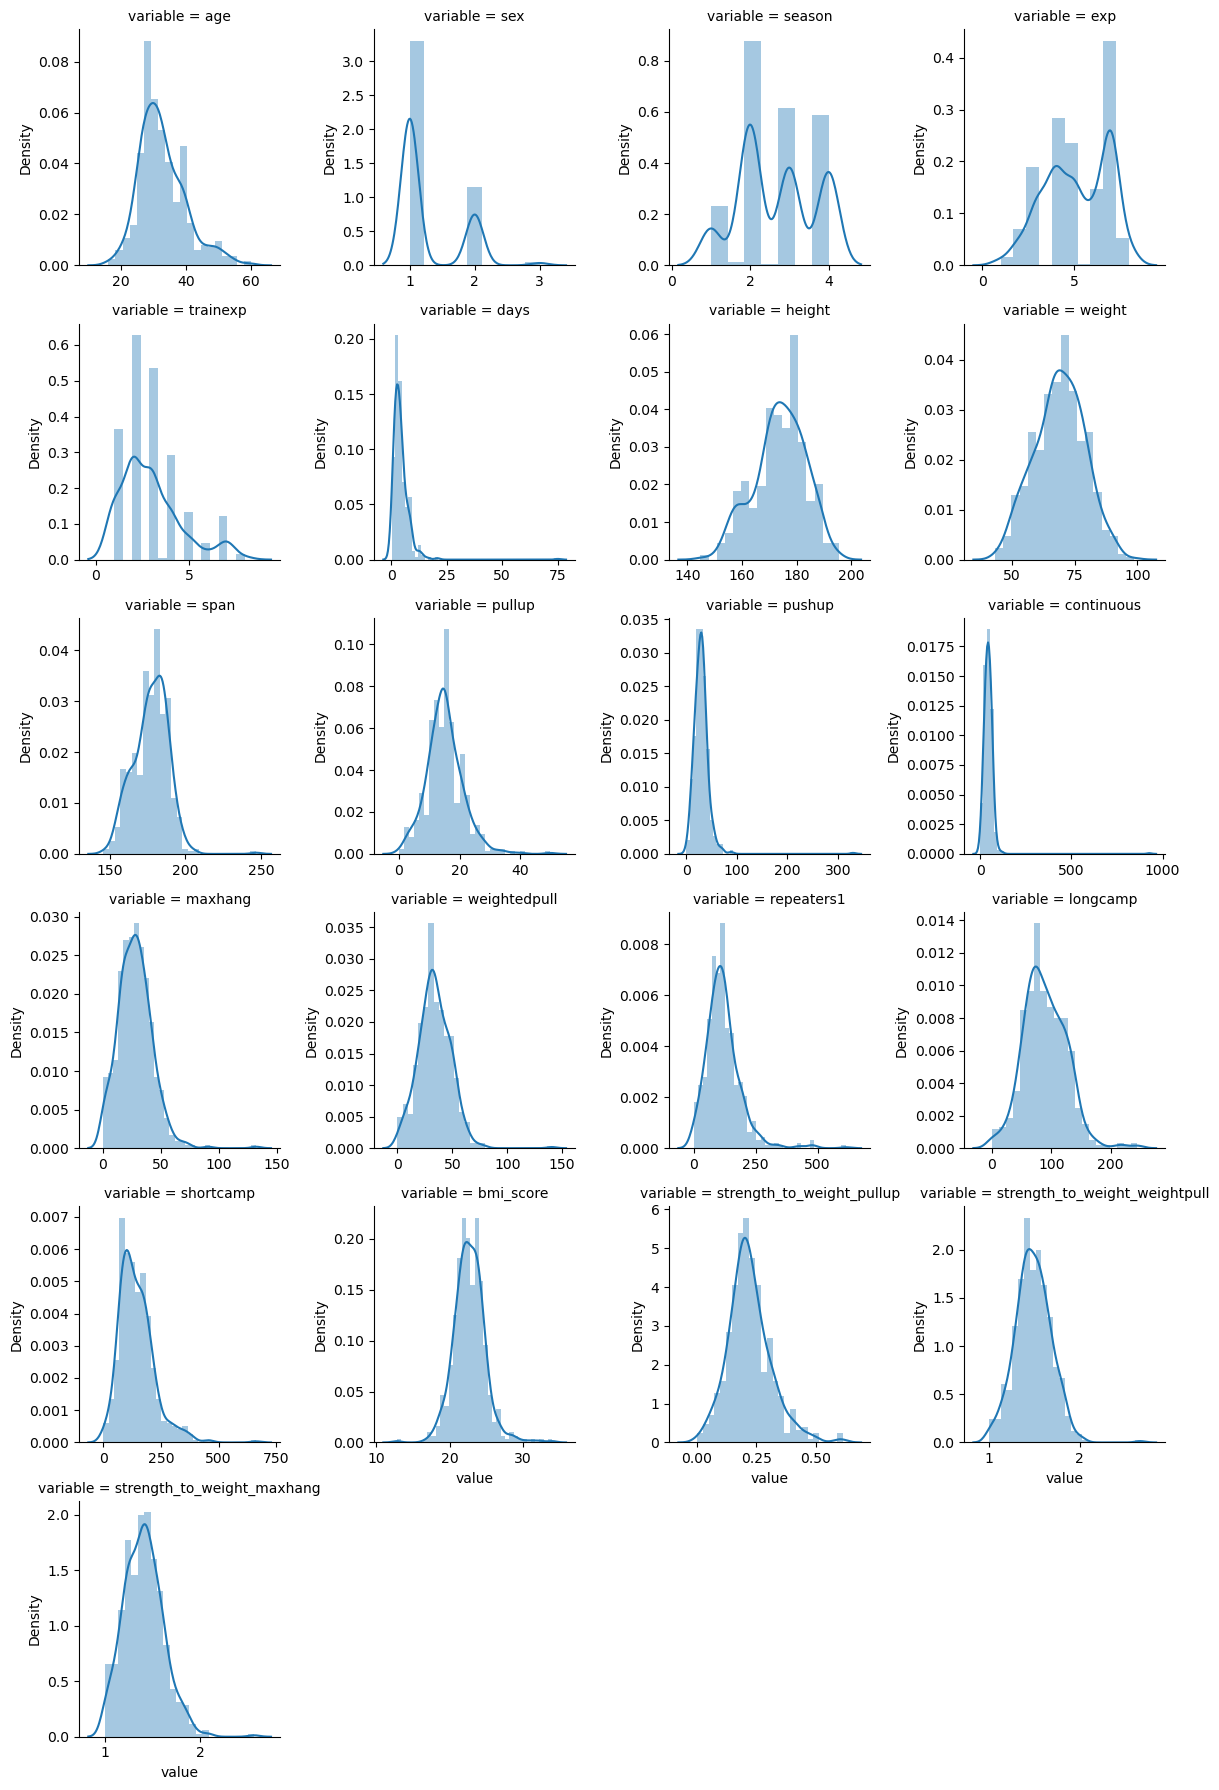

In [149]:
# select all the features of interest from the bouldering data
all_feat_bouldering = data_filtered_bouldering[["age","sex","season", "exp", "trainexp", "days",
                                                "height", "weight", "span", "pullup", "pushup", "continuous",
                                                "maxhang", "weightedpull", "repeaters1", "longcamp", 
                                                "shortcamp", "bmi_score", "strength_to_weight_pullup",
                                                "strength_to_weight_weightpull", "strength_to_weight_maxhang"]]

# melt the data to a long format where each row is a unique variable-value pair.
f = pd.melt(data_filtered_bouldering, value_vars=all_feat_bouldering)

# create a FacetGrid, which is a multi-plot grid for plotting conditional relationships.
g = sns.FacetGrid(f, col="variable", col_wrap=4, sharex=False, sharey=False)

# use the map function to plot a distribution plot for each variable on the FacetGrid.
g = g.map(sns.distplot, "value")

In this part of the script, the distribution of each variable in the data_filtered_bouldering dataframe is plotted to check if they follow a normal distribution. This is done using the seaborn library's FacetGrid and distplot functions, which create a grid of histograms for each variable.

From these plots, we can assess the distribution of each variable. If a variable's distribution significantly deviates from a normal distribution (e.g., if it is heavily skewed), it may need to be transformed (e.g., by taking the logarithm) before being used in a machine learning model.

The same is done below for the sport climbing dataset.

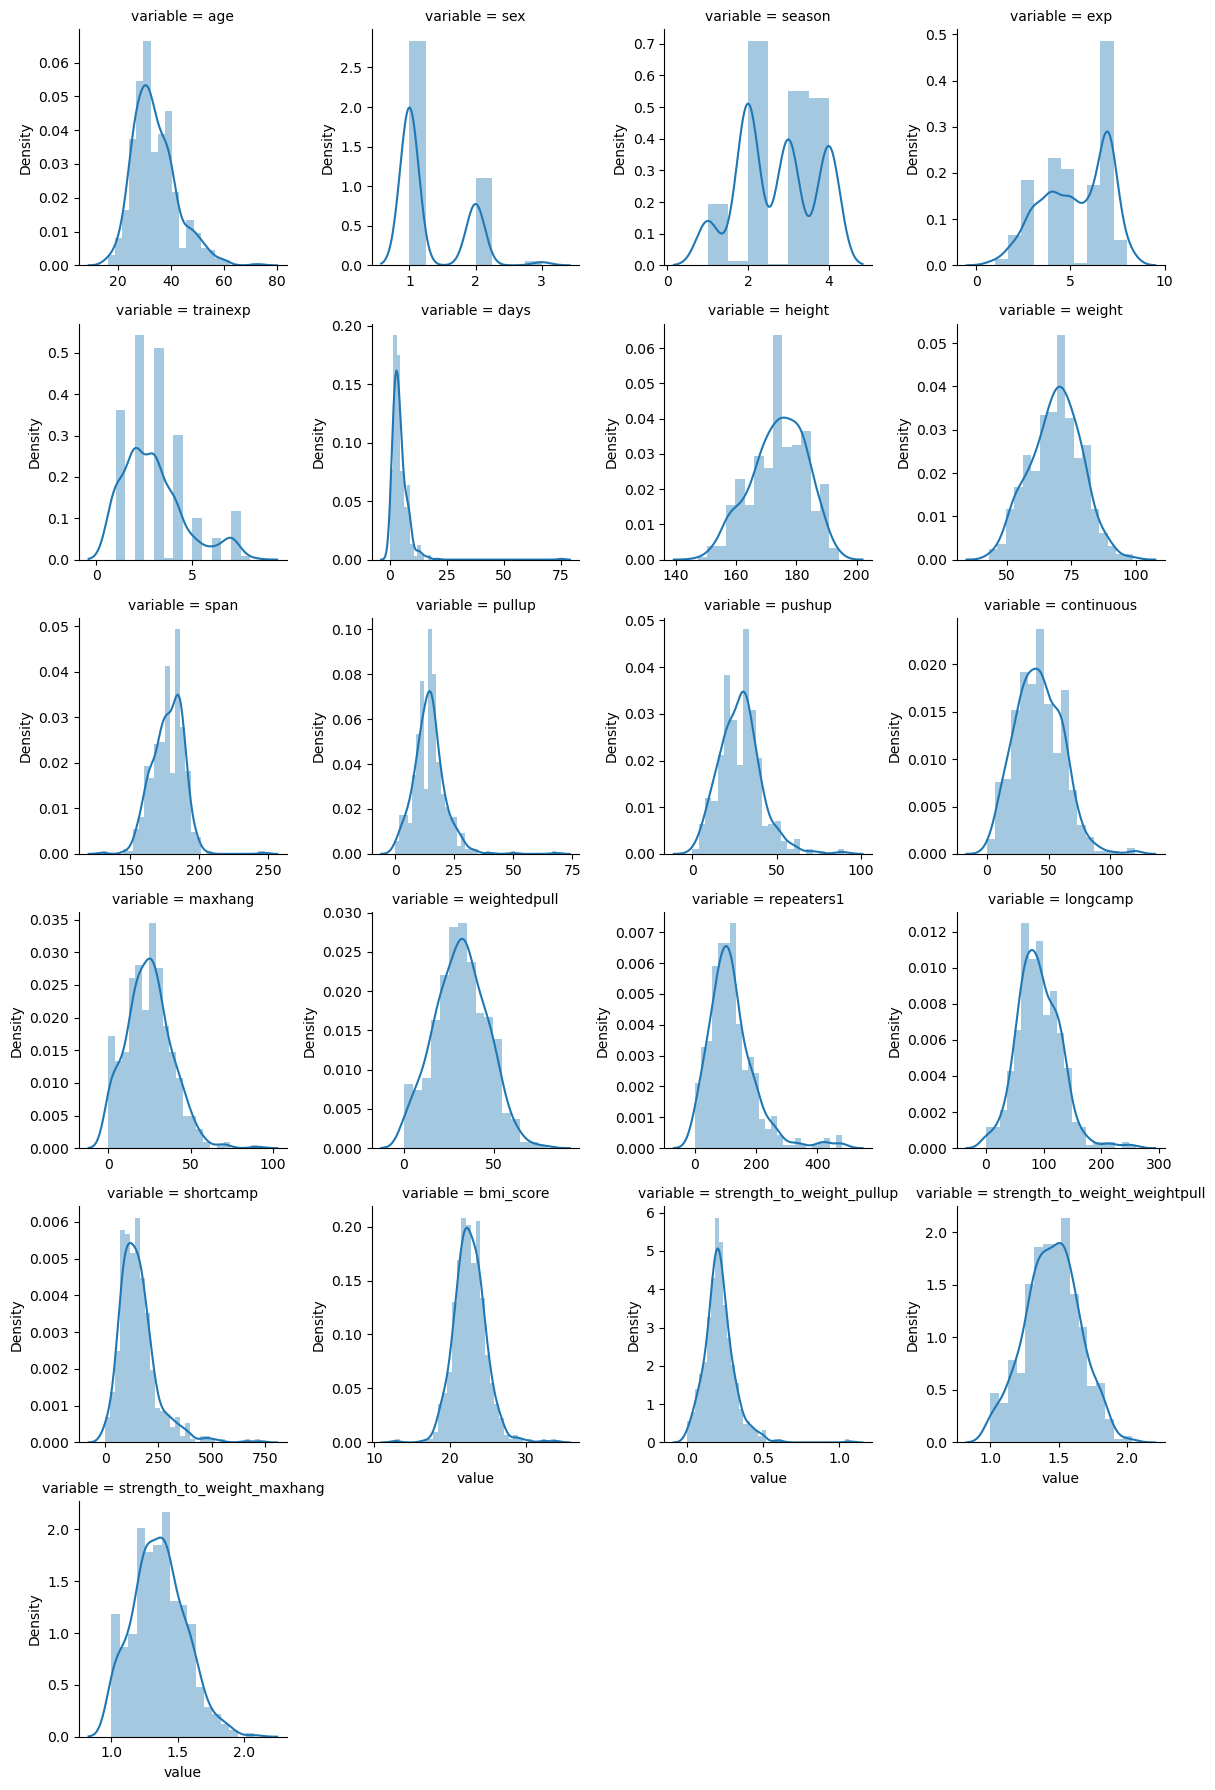

In [150]:
# select all the features of interest from the sport climbing data
all_feat_sport = data_filtered_sport[["age","sex","season", "exp", "trainexp", "days",
                                      "height", "weight", "span", "pullup", "pushup", "continuous",
                                      "maxhang", "weightedpull", "repeaters1", "longcamp", 
                                      "shortcamp", "bmi_score", "strength_to_weight_pullup",
                                      "strength_to_weight_weightpull", "strength_to_weight_maxhang"]]

# melt the data to a long format where each row is a unique variable-value pair.
f = pd.melt(data_filtered_sport, value_vars=all_feat_sport)

# create a FacetGrid, which is a multi-plot grid for plotting conditional relationships.
g = sns.FacetGrid(f, col="variable", col_wrap=4, sharex=False, sharey=False)

# use the map function to plot a distribution plot for each variable on the FacetGrid.
g = g.map(sns.distplot, "value")

By visualizing the distribution of each variable, we can gain insights about the structure of the data and identify any potential anomalies (e.g., a variable that has a single, dominant value), outliers, or trends that might warrant further investigation.

**Results**
All the variables look normally distributed so no further transformation is needed. There are some features (e.g. max hang, continuous, pushup) which seem to have a few data points significantly higher than the mean, but there aren't enough of them to skew the distribution.

Something that looks interesting is that for both bouldering and sport climbing is that training experience is right skewed and climbing experience is left skewed. This makes sense if we think about most climbers will have been climbing longer than they have been training for climbing - usually people will climb for a year or two before they start incorporating climbing specific training.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


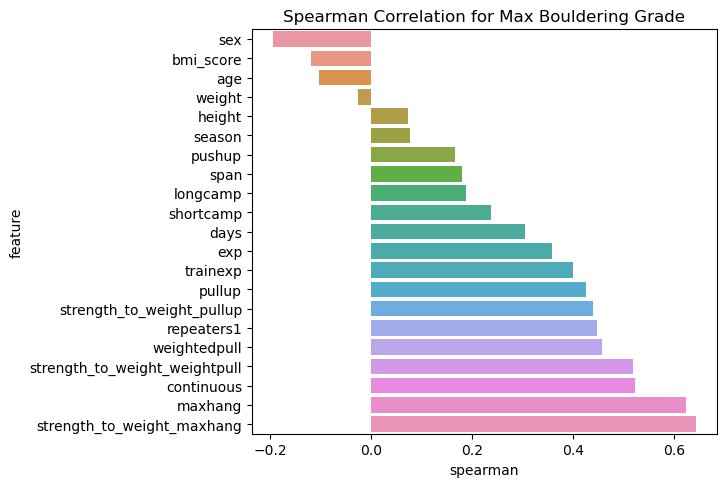

In [151]:
# spearman analysis for bouldering
def spearman(frame, features):
    # create an empty DataFrame
    spr = pd.DataFrame()

    # add a 'feature' column that contains all feature names
    spr['feature'] = features

    # add a 'spearman' column that contains the Spearman correlation of each feature with the max_boulder_numeric feature
    spr['spearman'] = [frame[f].corr(frame['max_boulder_numeric'], 'spearman') for f in features]

    spr = spr.sort_values('spearman')

    # create a bar plot of the Spearman correlations
    plt.figure(figsize=(6, 0.25 * len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    plt.title('Spearman Correlation for Max Bouldering Grade')

# call the function with the bouldering data
features = all_feat_bouldering.columns.tolist()
spearman(data_filtered_bouldering, features)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


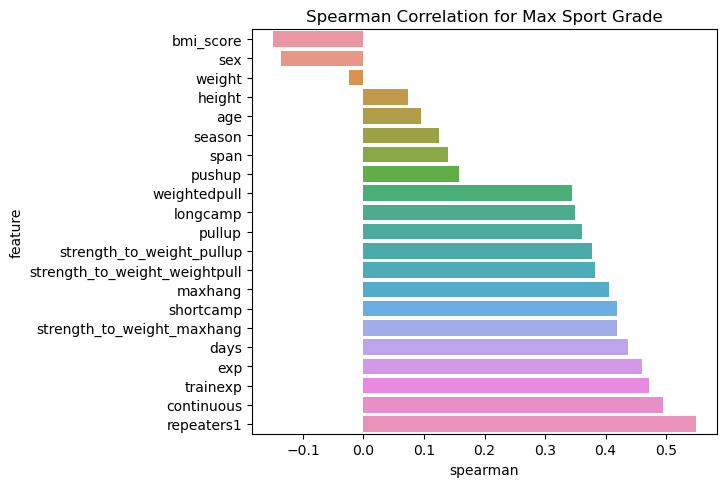

In [152]:
# spearman analysis for sport climbing
def spearman(frame, features):
    # create an empty DataFrame
    spr = pd.DataFrame()

    # add a 'feature' column that contains all feature names
    spr['feature'] = features

    # add a 'spearman' column that contains the Spearman correlation of each feature with the max_sport_numeric feature
    spr['spearman'] = [frame[f].corr(frame['max_sport_numeric'], 'spearman') for f in features]

    spr = spr.sort_values('spearman')

    # create a bar plot of the Spearman correlations
    plt.figure(figsize=(6, 0.25 * len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    plt.title('Spearman Correlation for Max Sport Grade')

# call the function with the sport climbing data
features = all_feat_sport.columns.tolist()
spearman(data_filtered_sport, features)

Here, two Spearman correlation analyses are being performed: one for bouldering and one for sport climbing. The Spearman correlation coefficient measures the strength and direction of monotonic relationship between two variables, without making any assumptions about the distributions of the variables.

Spearman's rank correlation coefficient is a non-parametric test that is used to measure the degree of association between two variables. It is a measure of a monotonic relationship (either increasing or decreasing, but not necessarily at a constant rate) between paired data. Non-parametric tests, in statistics, refer to a set of tests that do not assume a specific distribution for the data. Unlike parametric tests, which assume that the data follow a known distribution (typically a normal distribution), non-parametric tests make fewer assumptions about the data's structure.We know that most of our data is normally distributed, but non-parametric tests are also recommended for smaller sample sizes, so we can go ahead and use Spearman's here.

In this context, it is used to evaluate the relationship between each feature (age, sex, experience, etc.) and the maximum bouldering/sport climbing grades.

In the barcharts, features that have a strong positive Spearman correlation with the target variable are good predictors for climbing grades.

**Results**

Sex, BMI, Weight (and age for bouldering) are all of a low/negative correlation for both sport climbing and bouldering. Interestingly there are some differences between the most correlated features when comparing sport and bouldering, but somewhat expected.

Bouldering max grade tends to favour raw power so we can see strength to weight max hangs/weighted pullups in the top 5, with continuous hanging from a 20mm edge taking 3rd place. 

For sport climbing, there are more endurance based metrics taking the top spots: repeater and continuous hangs, as well as how many years of climbing experience people have. Strength to weight maxhangs take 5th place in terms of importance.

**Correlations** 

The correlation matrix is calculated using the .corr() method, which calculates the pairwise correlation of columns. Correlation indicates how strongly two variables are related to each other.

The .corr() method computes the correlation coefficient, a statistical measure that calculates the strength of the relationship between the relative movements of two variables. The range of values for the correlation coefficient is -1.0 to 1.0. A correlation of -1.0 shows a perfect negative correlation, while a correlation of 1.0 shows a perfect positive correlation. A correlation of 0.0 shows no linear relationship between the movement of the two variables.

In the heatmaps, a darker color in either direction (dark blue or dark red) indicates a stronger correlation. A positive correlation (red) means that as one variable increases, the other tends to increase as well. A negative correlation (blue) means that as one variable increases, the other tends to decrease. The stronger the color, the stronger the correlation.

**Results**

We are seeing similar results to our Spearman analysis which is good sign and tells us we can have some confidence in the variables we choose for our ML models. It's also interesting to note the difference we see already between bouldering and sport climbing where endurance based metrics like continuous and repeaters have a more important role to play with max sport climbing, which makes sense.

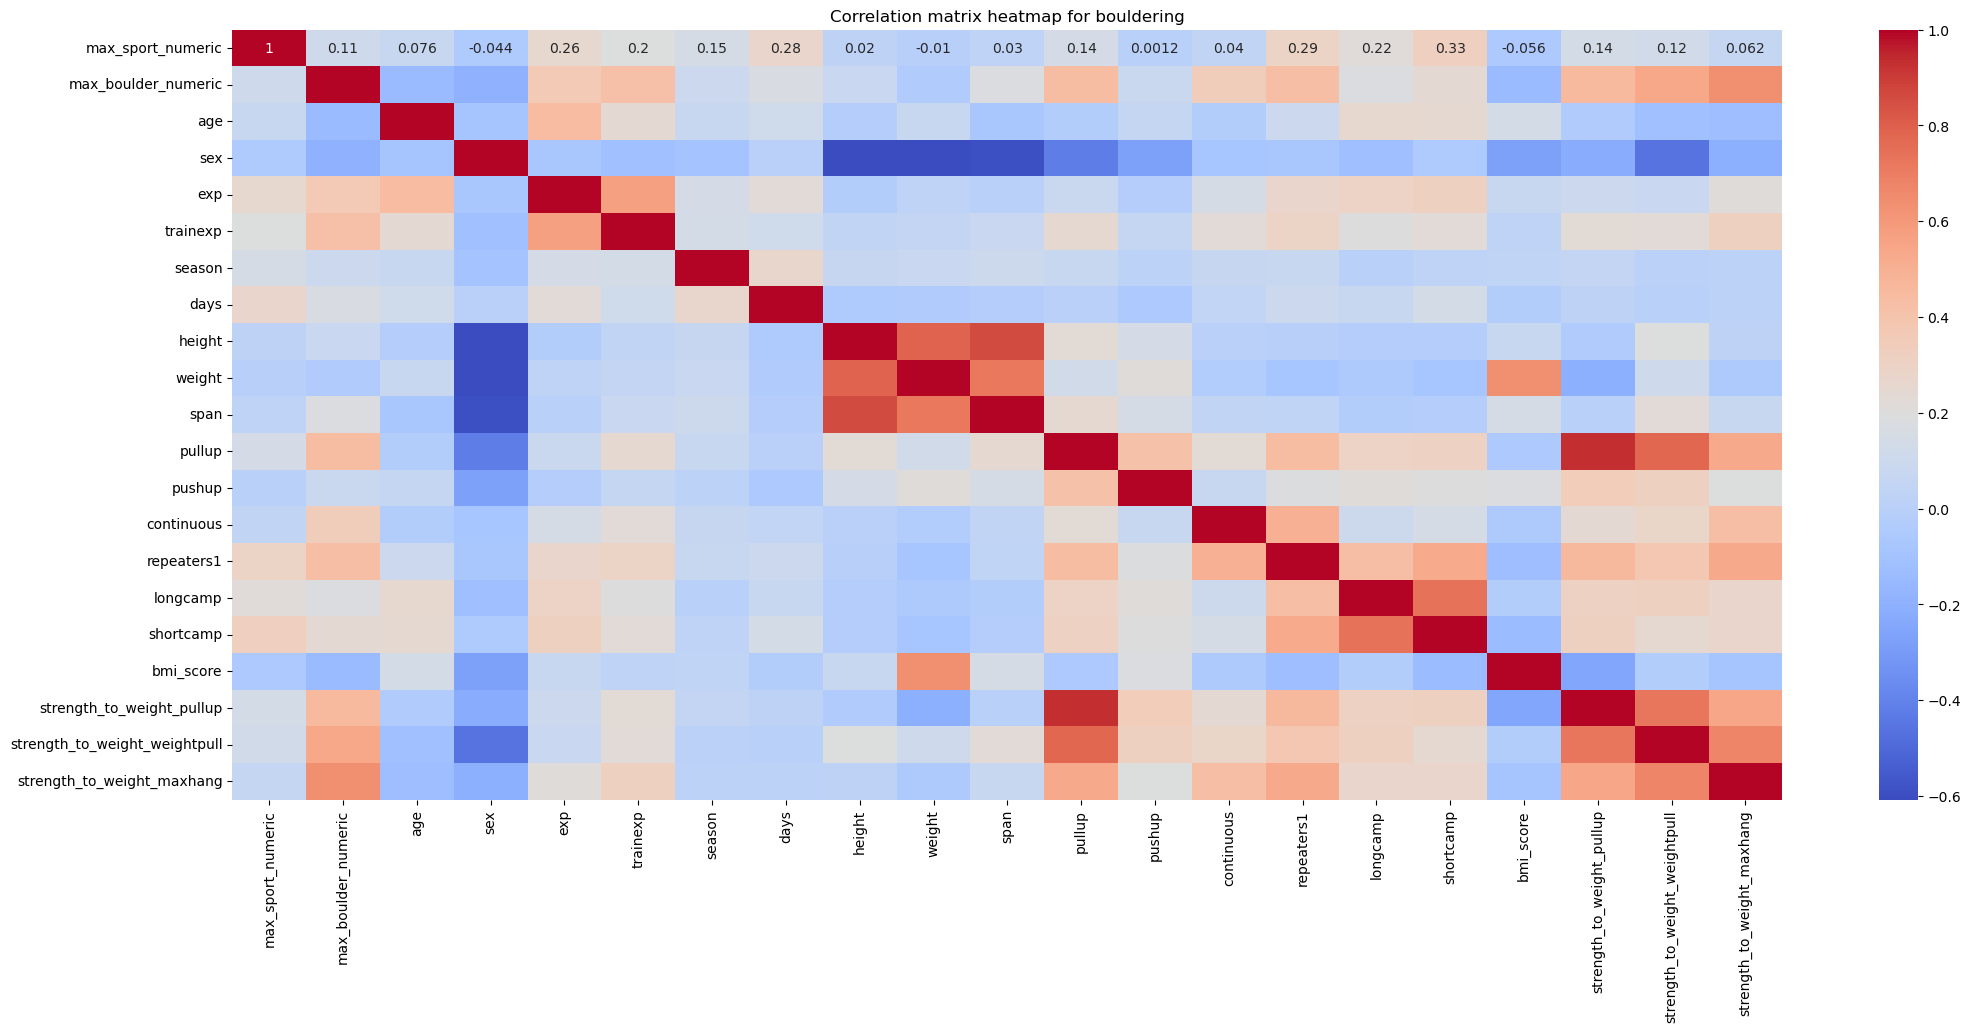

In [153]:
# calculate the correlation matrix for the specified columns in the bouldering data
corr = data_filtered_bouldering[[
    "max_sport_numeric", "max_boulder_numeric", "age", "sex", "exp", "trainexp",
    "season", "days", "height", "weight", "span", "pullup", "pushup", "continuous",
    "repeaters1", "longcamp", "shortcamp", "bmi_score", "strength_to_weight_pullup",
    "strength_to_weight_weightpull", "strength_to_weight_maxhang"
]].corr()

# create a new figure with a specified size
plt.figure(figsize=(25, 10))

# create a heatmap of the correlation matrix
# 'annot=True' makes the correlation values visible on the heatmap
# 'cmap' sets the color map to 'coolwarm', which is a diverging colormap
sns.heatmap(corr, annot=True, cmap='coolwarm')


plt.title("Correlation matrix heatmap for bouldering")
plt.show()

Since we have categorical features as well as numerical, e.g. sex, it was suggested that I also complete an ANCOVA model to determine if there is a significant difference between male/female/other and max climbing grades. When I analysed the results, it was interesting to see that some variables like strength_to_weight_pullup, and strength_to_weight_maxhang have p-values above 0.05, indicating that they are not statistically significant predictors of the dependent variable. 

However I chose to ignore this, as the rest of data points towards these having a significant impact on max bouldering grade - I also have domain knowledge about this, so I know that there must be something incorrect with the way I've set up the ANCOVA test, rather than these features actually not being significant predictors of max bouldering grades.

In [154]:
# define formula for the ANCOVA model
formula = "max_boulder_numeric ~ age + sex + season + exp + trainexp + days + height + weight + span + pullup + pushup + continuous + maxhang + weightedpull + repeaters1 + longcamp + shortcamp + bmi_score + strength_to_weight_pullup + strength_to_weight_weightpull + strength_to_weight_maxhang"
# create a model using the formula
model = ols(formula, data=data_filtered_bouldering).fit()
# ANCOVA
results = sm.stats.anova_lm(model)
print(results)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                                  df       sum_sq     mean_sq           F  \
age                              1.0    70.220274   70.220274   27.356276   
sex                              1.0   135.209202  135.209202   52.674535   
season                           1.0    24.543891   24.543891    9.561761   
exp                              1.0   695.728744  695.728744  271.040638   
trainexp                         1.0   173.091036  173.091036   67.432466   
days                             1.0    30.838708   30.838708   12.014083   
height                           1.0     4.473043    4.473043    1.742599   
weight                           1.0   122.365482  122.365482   47.670904   
span                             1.0    56.525814   56.52

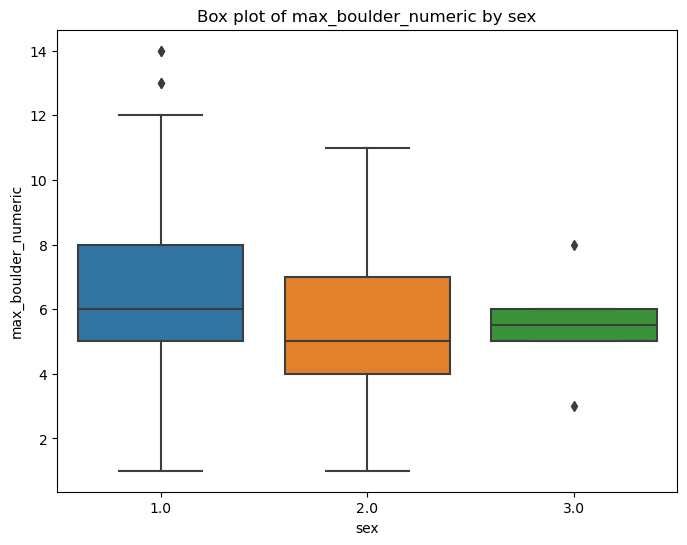

In [155]:
# create a box plot for sex vs. max_bouldering_numeric to determine if any differences between genders
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='max_boulder_numeric', data=data_filtered_bouldering)
plt.title('Box plot of max_boulder_numeric by sex')
plt.show()

For max bouldering, it doesn't seem like there is a significant difference between males (1) and females (2) when it comes to max bouldering grades - although we should note that males tend to have a higher max grade.

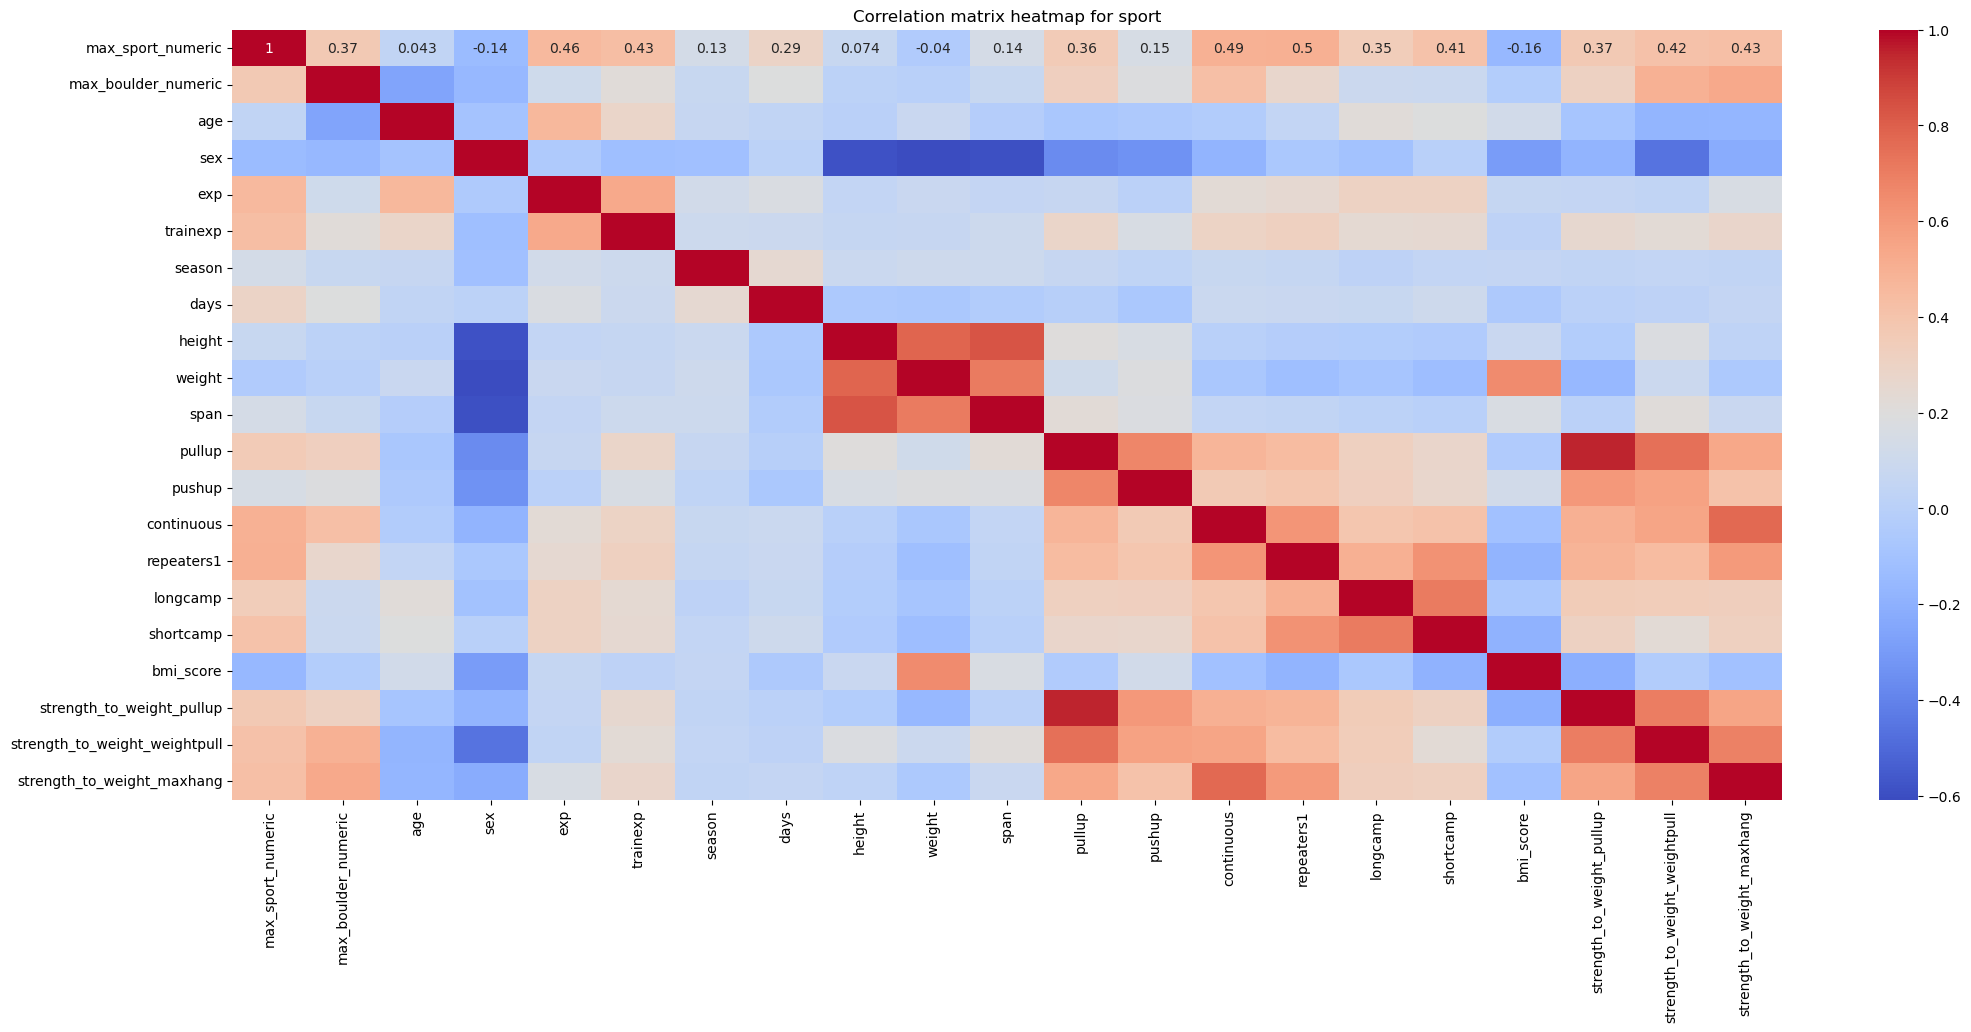

In [156]:
# calculate the correlation matrix for the specified columns in the sport data
corr = data_filtered_sport[[
    "max_sport_numeric", "max_boulder_numeric", "age", "sex", "exp", "trainexp",
    "season", "days", "height", "weight", "span", "pullup", "pushup", "continuous",
    "repeaters1", "longcamp", "shortcamp", "bmi_score", "strength_to_weight_pullup",
    "strength_to_weight_weightpull", "strength_to_weight_maxhang"
]].corr()

# create a new figure with a specified size
plt.figure(figsize=(25, 10))

# create a heatmap of the correlation matrix
# 'annot=True' makes the correlation values visible on the heatmap
# 'cmap' sets the color map to 'coolwarm', which is a diverging colormap
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.title("Correlation matrix heatmap for sport")
plt.show()

In the below ANCOVA model, sex has a very low p-value (close to 0), indicating it is highly statistically significant. It suggests that the sex variable significantly affects max_sport_numeric.Continuous, maxhang, weightedpull, repeaters1, and shortcamp have lower p-values, suggesting some level of significance, but not as strong as the sex. Strength_to_weight_pullup, strength_to_weight_weightpull, and strength_to_weight_maxhang have high p-values, indicating that they are not statistically significant predictors of max_sport_numeric.

Again, as above, I decided to use domain expertise and the results of the rest of the analysis when thinking about these results. Sex could very well have an important role to play when predicting max sport climbing grade, so I will analyse that one further with a box plot. I am not convinced about the rest of the features though like strength to weight pullup/weightedpullups/maxhangs - I know from experience and other similar analyses that these features do play a role, and usually quite an important one.

In [157]:
# formula for the ANCOVA model
formula = "max_sport_numeric ~ age + sex + season + exp + trainexp + days + height + weight + span + pullup + pushup + continuous + maxhang + weightedpull + repeaters1 + longcamp + shortcamp + bmi_score + strength_to_weight_pullup + strength_to_weight_weightpull + strength_to_weight_maxhang"
# create a model using the formula
model = ols(formula, data=data_filtered_sport).fit()
# ANCOVA
results = sm.stats.anova_lm(model)
print(results)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                                  df       sum_sq      mean_sq           F  \
age                              1.0    10.301390    10.301390    1.885762   
sex                              1.0   104.927468   104.927468   19.207914   
season                           1.0    77.552177    77.552177   14.196621   
exp                              1.0  1308.725915  1308.725915  239.574013   
trainexp                         1.0   275.080767   275.080767   50.356001   
days                             1.0   231.017074   231.017074   42.289747   
height                           1.0     1.947207     1.947207    0.356454   
weight                           1.0   226.734373   226.734373   41.505760   
span                             1.0    54.49839

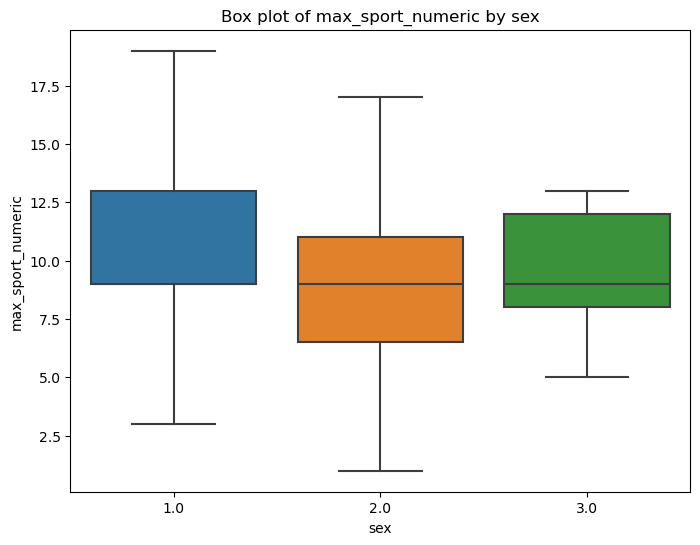

In [158]:
# Create a box plot for sex vs. max_sport_numeric to determine if any differences between genders
plt.figure(figsize=(8, 6))
sns.boxplot(x='sex', y='max_sport_numeric', data=data_filtered_sport)
plt.title('Box plot of max_sport_numeric by sex')
plt.show()

Results are slightly different to the max bouldering grade vs sex box plots, so we could argue that sex does play a role in predicting max sport grade. I am choosing to keep this as information rather than incorporating it into the model for a number of reasons, but mainly that I would prefer not to ask for gender on the applet when asking individuals to provide their actual climbing values.

Text(0.5, 0.98, 'Max Bouldering')

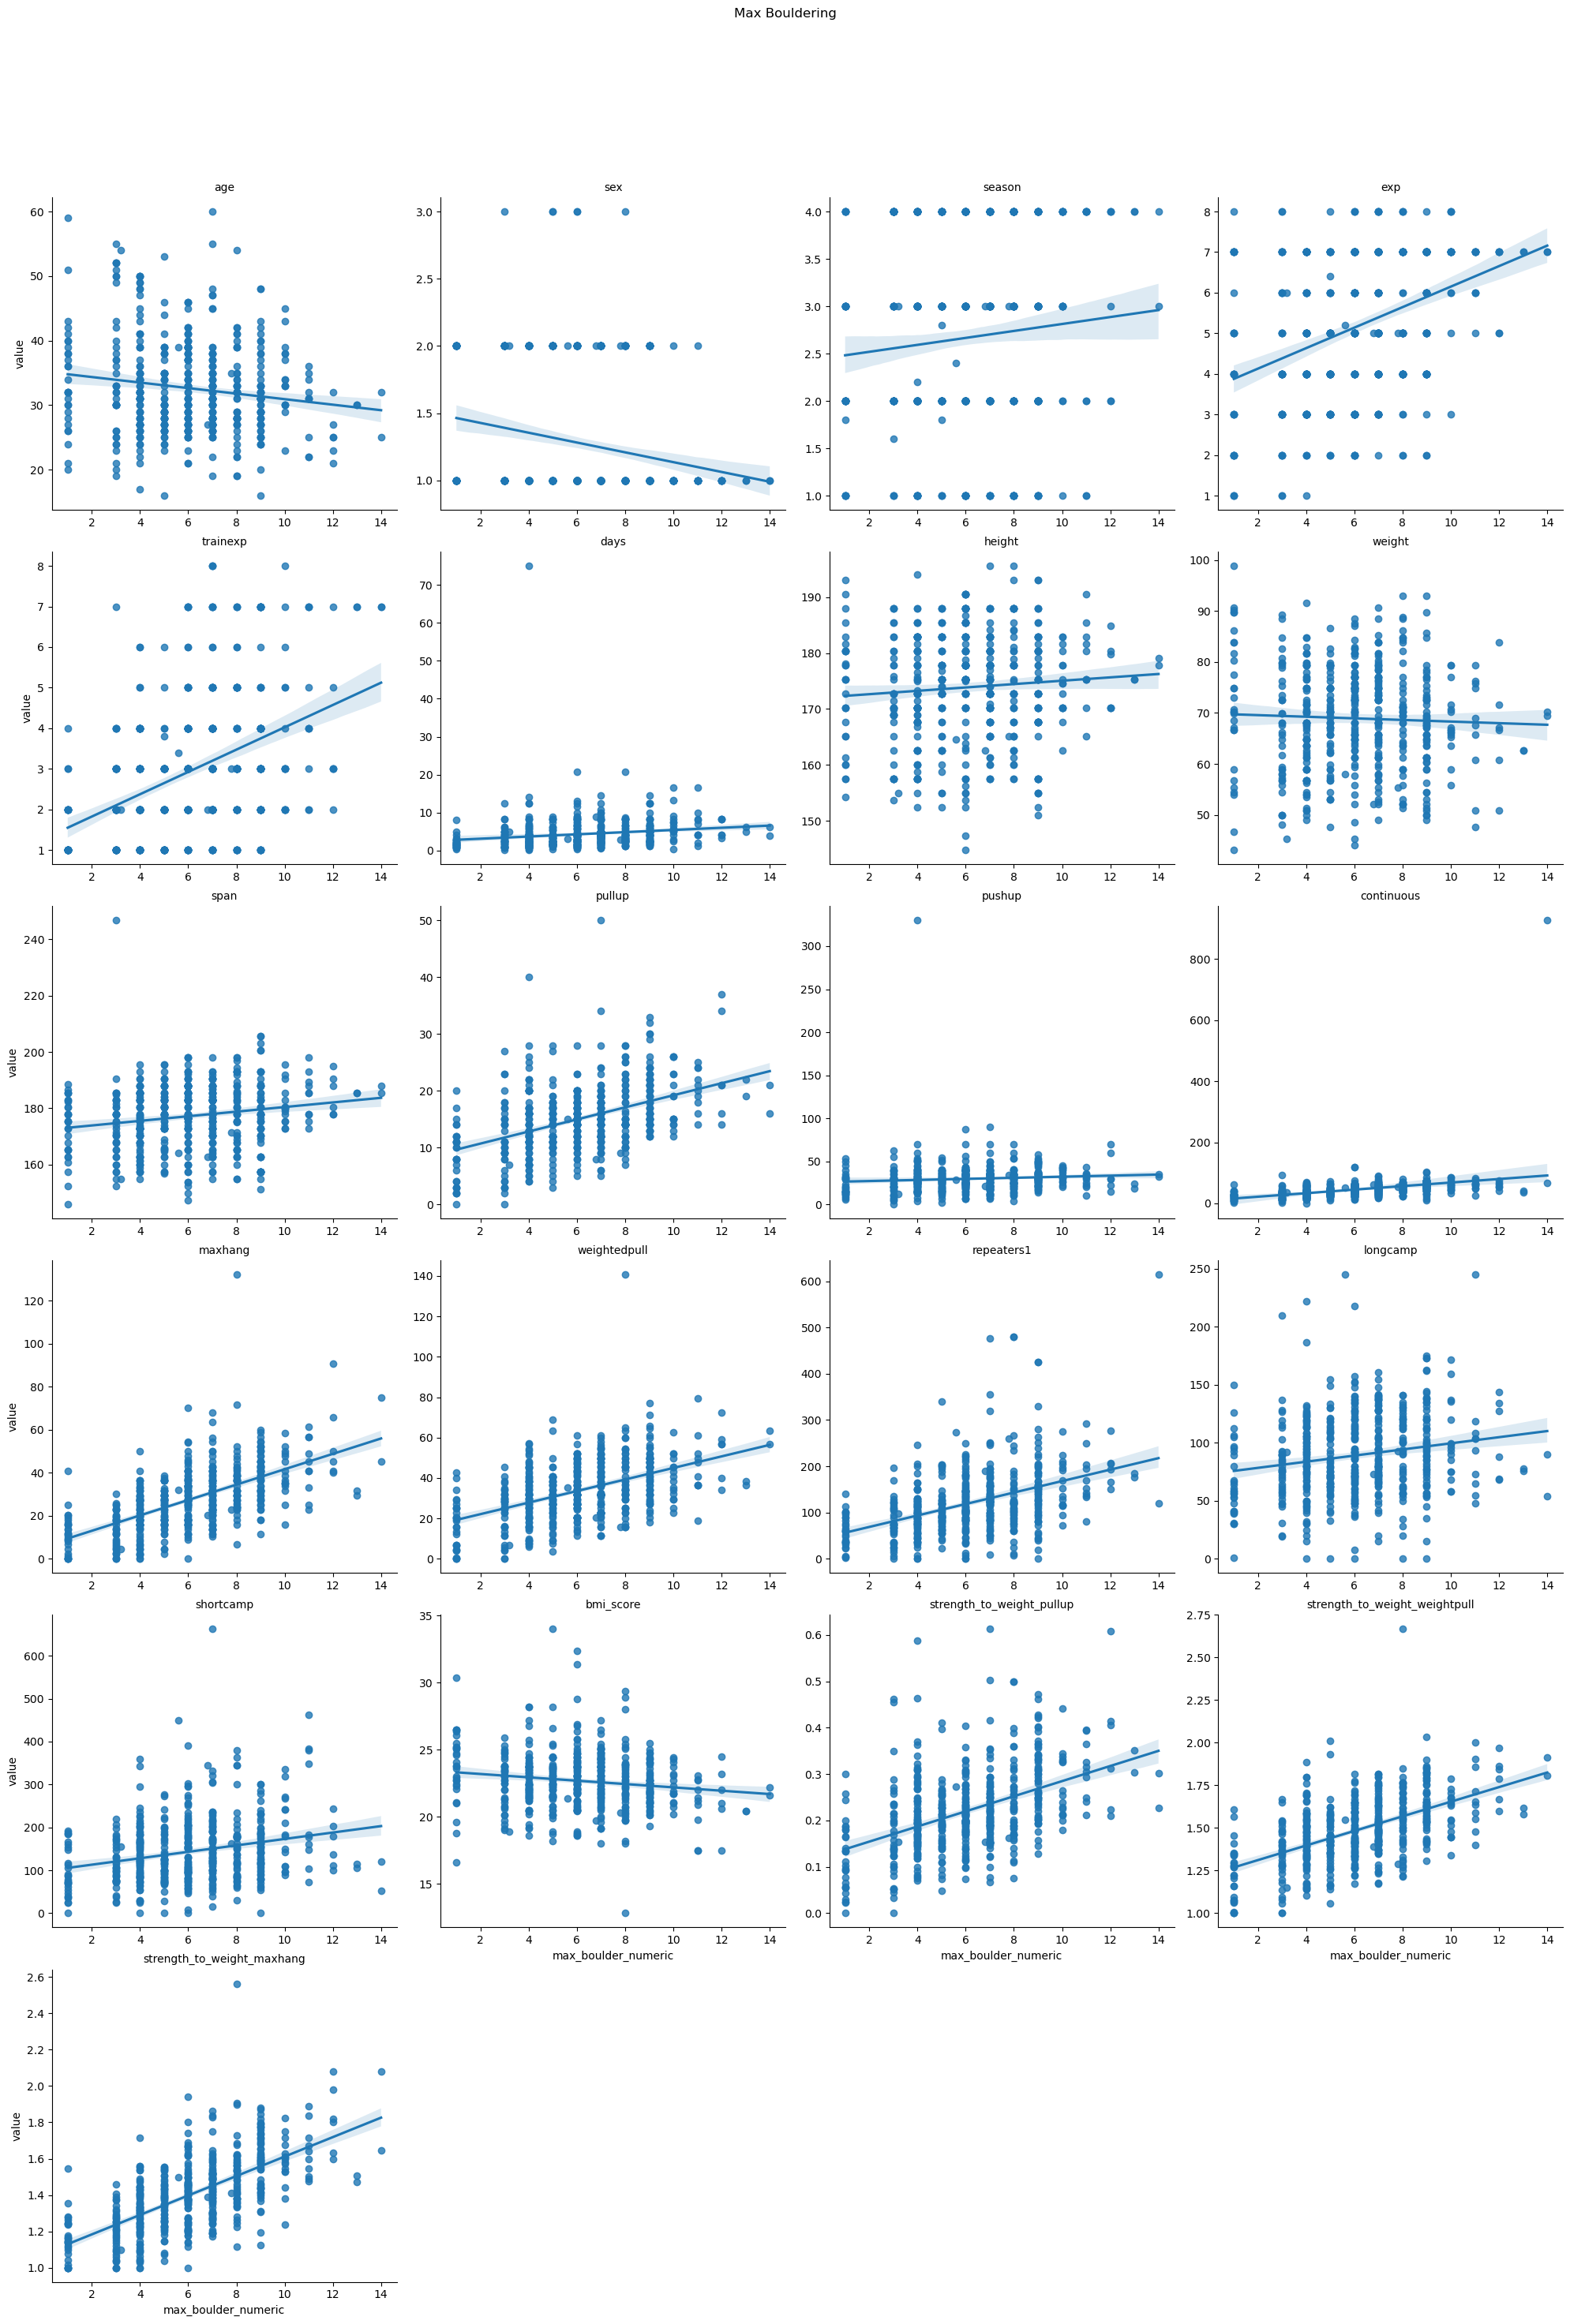

In [159]:
# melt the DataFrame, keeping 'max_boulder_numeric' fixed and converting the columns in 'all_feat_bouldering' into a single column
f = pd.melt(data_filtered_bouldering, id_vars=['max_boulder_numeric'], value_vars=all_feat_bouldering)

# create a FacetGrid object with a subplot for each feature in 'all_feat_bouldering'
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=5)

# map a regplot to each subplot, plotting 'max_boulder_numeric' against the feature values
g = g.map(sns.regplot, "max_boulder_numeric", "value").set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Max Bouldering')

Text(0.5, 0.98, 'Max Sport')

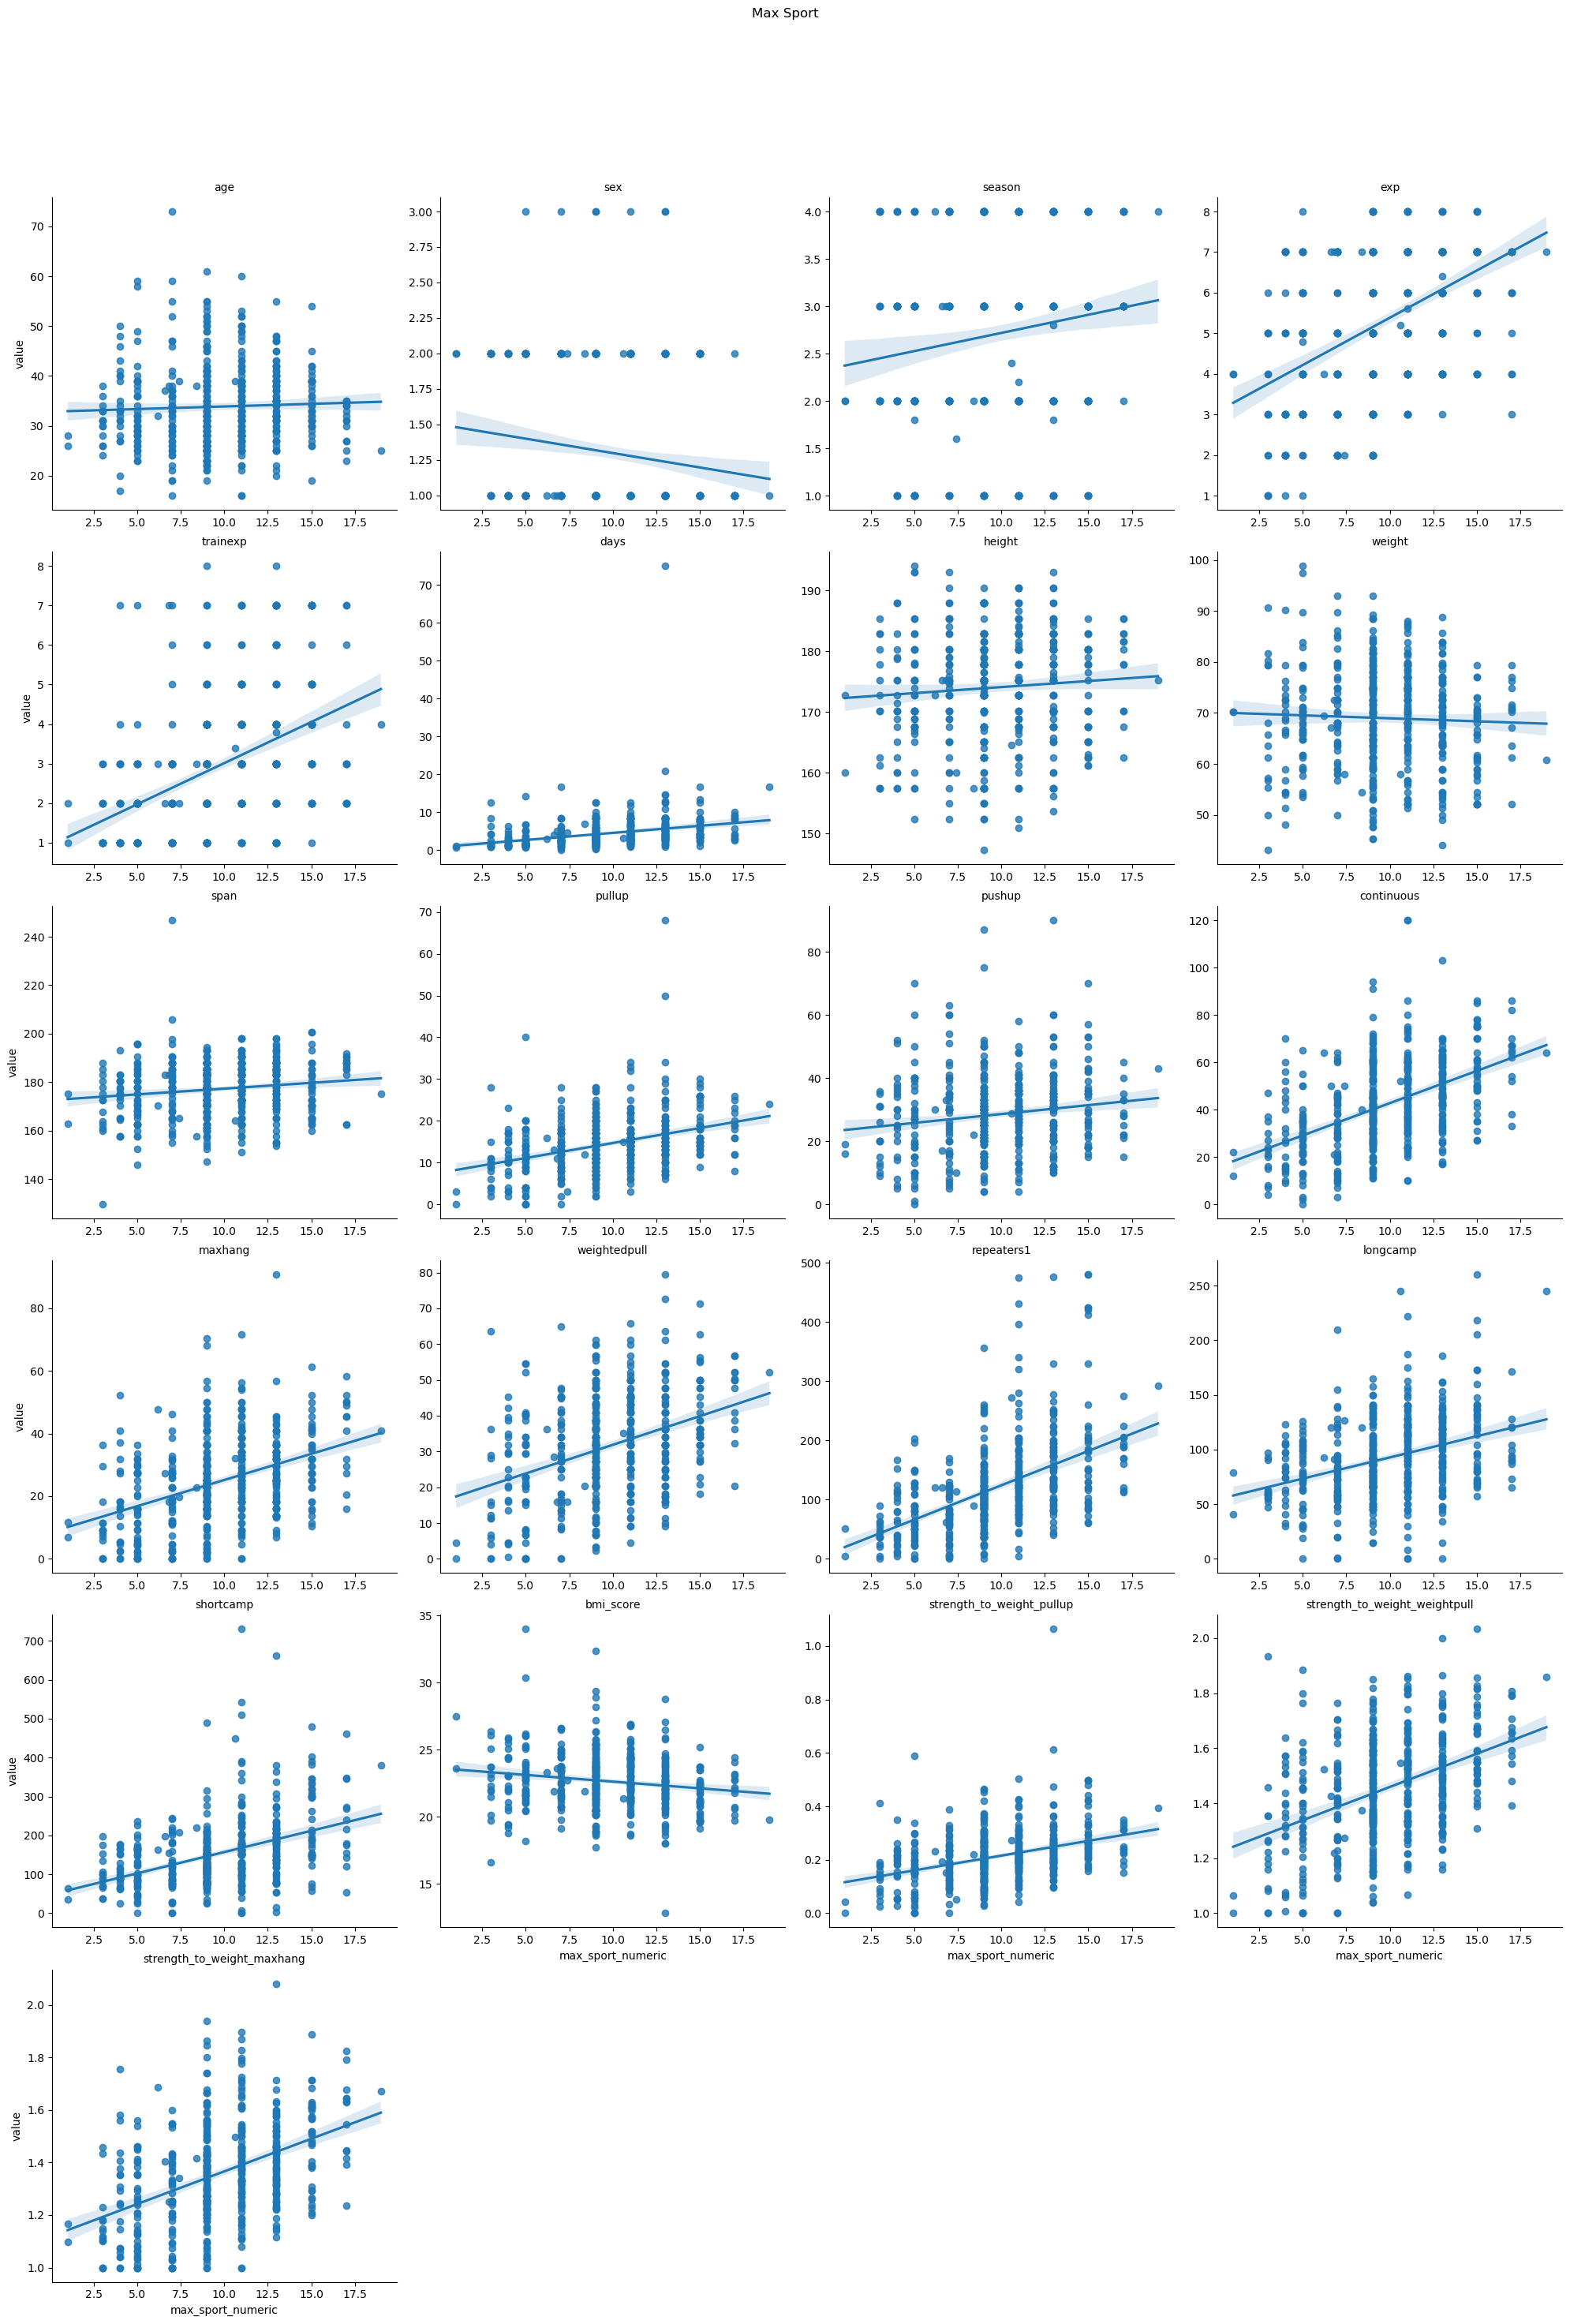

In [160]:
# melt the DataFrame, keeping 'max_sport_numeric' fixed and converting the columns in 'all_feat_sport' into a single column
f = pd.melt(data_filtered_sport, id_vars=['max_sport_numeric'], value_vars=all_feat_sport)

# create a FacetGrid object with a subplot for each feature in 'all_feat_bouldering'
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=5)

# map a regplot to each subplot, plotting 'max_boulder_numeric' against the feature values
g = g.map(sns.regplot, "max_sport_numeric", "value").set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Max Sport')

The graphs above are another way of representing the relationships between each feature and the max bouldering/sport climbing grades. The trend lines are calculated using regression, which attempts to draw a straight line to indicate the relationship between the variable the max_sport/bouldering_grade. 

There are some features which are not suitable for this type of plotting (e.g. season and sex) however I have included them to avoid creating multiple filters of my dataset. For other features where we do expect to see some type of relationship, it's clear where the relationship is neutral, slightly positive, or highly positive (e.g. strength to weight maxhang is highly positive when looking at both sport and bouldering max grades)


Using all the methods above we can validate which metrics to include in our ML models for sport and bouldering.

![Silence](https://www.lacrux.com/wp-content/uploads/2018/04/Warum-Adam-Ondra-Silence-mit-9c-bewertete-1024x444.jpg)

In the following section I am testing out 3 different models to try and find the one that most accurately predicts bouldering and sport max grade. I will be using a linear regression model, gradient boosting model, and random forest model.

**Model Information**

For information (I didn't know much about these before and want to keep the notes here for future reference):

Linear Regression: Linear regression models are one of the simplest types of predictive models. They model the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data. The steps to obtain the equation are deterministic, meaning that you'll get the same model each time you run a linear regression with the same data and the same settings. Linear regression models are interpretable, but they can oversimplify real-world problems by assuming a linear relationship between variables.

Gradient Boosting: Gradient boosting models are a type of ensemble learning model. They combine the predictions of multiple "weak" models to make a final prediction. In the case of gradient boosting, the models (often decision trees) are built sequentially. Each new model attempts to correct the errors made by the previous models. This is achieved by fitting the new model to the residuals (i.e., the differences between the predicted and true values) of the previous model, hence "gradient" (referring to the direction of steepest descent towards minimizing error) and "boosting" (referring to the combination of many models). Gradient boosting models often have high predictive accuracy, but they can be prone to overfitting and are less interpretable than linear regression models.

Random Forest: Random forest models are another type of ensemble learning model. Like gradient boosting, they combine the predictions of multiple models (in this case, decision trees), but the trees are built in parallel rather than sequentially. In a random forest, each tree is trained on a random subset of the data, and each split in each tree is chosen from a random subset of the features. This randomness helps to make the model robust to overfitting. Random forest models are typically less prone to overfitting than gradient boosting models, and they also provide measures of feature importance, which can be useful for interpretation.

In summary, linear regression models are simple and interpretable but can oversimplify complex relationships. Gradient boosting and random forest models can capture more complex relationships and often have higher predictive accuracy, but they can be prone to overfitting (particularly gradient boosting) and are less interpretable. The best model to use depends on the specifics of the data and the analytical goals.

I will also be looking at feature importance and SHAP values. 

**Feature Importance**

Feature importance in machine learning provides a score that indicates how useful or valuable each feature was in the construction of the machine learning model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

Here are brief explanations of feature importance in the context of the three models I have used:

Linear Regression: In linear regression, the coefficient size can often be used as an indication of feature importance. A larger coefficient means that the feature has a stronger impact on the prediction. However, it's important to note that this interpretation assumes that all features have been appropriately scaled to the same range (e.g., -1 to 1).

Random Forest: In a random forest model, feature importance is usually calculated by looking at how much the tree nodes that use that feature reduce impurity across all trees in the forest. It computes this score automatically for each feature after training and scales the results so that the sum of all importances is equal to 1.

Gradient Boosting: Like a random forest, gradient boosting provides a feature importance score based on the reduction of the criterion used to split the nodes (like Gini or entropy for classification, variance for regression). However, since gradient boosting involves creating trees in a serial manner where each new tree helps to correct errors made by previously trained trees, the feature importance calculation can be slightly different. There's also a method to compute feature importance by "permutation", where the model's performance is assessed with each feature's values randomly shuffled - a large decrease in performance indicates high feature importance.

**SHAP Values**

SHAP (SHapley Additive exPlanations) values interpret the impact of having a certain value for a given feature in comparison to the prediction we would make if that feature took some baseline value.

Here are some insights you can get from SHAP values:

Feature Importance: Features with larger SHAP values (either positive or negative) are more important in the model's decision-making process. This can help you understand which features are driving the predictions.

Effect of Feature Values: Positive SHAP values for a given feature indicate that the high values of that feature increase the prediction, while negative SHAP values mean that high values of that feature decrease the prediction. In other words, if a feature has a positive SHAP value, it means it's pushing the model's output higher than the base value, and vice versa for a negative SHAP value.

**Feedback loop**

Following the launch of the applet on Streamlit, I have been collecting user data which I will be using to re-train and improve the models periodically. Users are asked to input their actual max sport and bouldering grades, alongside their strength metrics. This data is then sent to and stored in MongoDB, from where I access it. 

Below, I am importing that data, applying the conversion mappings for bouldering and sport grades, and then imputing any 0 values (e.g. some users input a max bouldering grade but not a max sport grade). This cleaned and updated data will be joined on to the data used in the models.


In [161]:
# import csv file of new data from mongo db
new_data_mongodb = pd.read_csv(r"new_data_mongodb.csv")

In [162]:
# map the French grades to numerical values
new_data_mongodb['max_sport_numeric'] = new_data_mongodb['max_sport_grade'].map(conversion_map_french)
# apply the conversion function to the 'max_boulder' column to create a new column of numeric V grades
new_data_mongodb['max_boulder_numeric'] = new_data_mongodb['max_boulder_grade'].apply(convert_v_grade_to_numeric)

In [163]:
# drop the max_sport_grade and max_boulder_grade columns
new_data_mongodb = new_data_mongodb.drop(columns=["max_sport_grade", "max_boulder_grade"])
print(new_data_mongodb.columns)  # print the dataframe to confirm the columns have been dropped

Index(['strength_to_weight_pullup', 'strength_to_weight_maxhang',
       'strength_to_weight_weightpull', 'continuous', 'repeaters1', 'exp',
       'trainexp', 'days', 'max_sport_numeric', 'max_boulder_numeric'],
      dtype='object')


In [164]:
# replace all NaNs with 0s in the new_data_mongodb dataframe
new_data_mongodb = new_data_mongodb.fillna(0)
# print any rows which contan NaNs
print(new_data_mongodb[new_data_mongodb.isna().any(axis=1)])

Empty DataFrame
Columns: [strength_to_weight_pullup, strength_to_weight_maxhang, strength_to_weight_weightpull, continuous, repeaters1, exp, trainexp, days, max_sport_numeric, max_boulder_numeric]
Index: []


In [165]:
# impute 0s in new_data_mongo_db
# store column names before imputation
column_names = new_data_mongodb.columns
# perform imputation
new_data_mongodb_imputed = knn_imputer.fit_transform(new_data_mongodb)
# convert the result back to a DataFrame
new_data_mongodb = pd.DataFrame(new_data_mongodb_imputed, columns=column_names)

In [166]:
# define the independent variables for bouldering which we want to use in the models
# exclude highly correlated variableslike pullup and strength_to_weight_pullup since one is based on the other
independent_vars_bouldering = ['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','continuous','exp','days']
#'days']

In [167]:
# define the independent variables for sport which we want to use in the models
# exclude highly correlated variableslike pullup and strength_to_weight_pullup since one is based on the other
independent_vars_sport = ['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','continuous','repeaters1','exp','days']
                          #'days']

In [168]:
# Concatenate the new data with the existing bouldering and sport datasets
data_filtered_bouldering = pd.concat([data_filtered_bouldering, new_data_mongodb], axis=0, ignore_index=True)
data_filtered_sport = pd.concat([data_filtered_sport, new_data_mongodb], axis=0, ignore_index=True)

In [169]:
# check how many rows we have and compare against the original dataset (pre mongo db import)
print(len(data_filtered_bouldering))
print(len(data_filtered_sport))

568
546


In [170]:
# save data filtered bouldering and sport to csv files
data_filtered_bouldering.to_csv(r'/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/data_filtered_bouldering.csv')
data_filtered_sport.to_csv(r'/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/data_filtered_sport.csv')

In [171]:
# final check: show NaN values in the bouldering and sport datasets we are using to train the models
print(data_filtered_bouldering[independent_vars_bouldering].isna().sum())
print(data_filtered_sport[independent_vars_sport].isna().sum())

strength_to_weight_pullup        0
strength_to_weight_maxhang       0
strength_to_weight_weightpull    0
continuous                       0
exp                              0
days                             0
dtype: int64
strength_to_weight_pullup        0
strength_to_weight_maxhang       0
strength_to_weight_weightpull    0
continuous                       0
repeaters1                       0
exp                              0
days                             0
dtype: int64


In [172]:
# define the personal variables in each of the [] brackets for bouldering
# this is used to predict a user's max bouldering grade
new_data_bouldering = pd.DataFrame(
    {'strength_to_weight_pullup': [1.5], 
     'strength_to_weight_maxhang': [1.8], 
     'strength_to_weight_weightpull': [3.8],
     'continuous':[60],
     'exp': [4],
     'days': [8]
})

In [173]:
# define the personal variables in each of the [] brackets for sport climbing
# this is used to predict a user's max sport grade
new_data_sport = pd.DataFrame(
    {'strength_to_weight_pullup': [1.5], 
     'strength_to_weight_maxhang': [4], 
     'strength_to_weight_weightpull': [3.8],
     'continuous': [80],
     'repeaters1':[120],
     'exp': [4],
    #  'trainexp': [2]
     'days': [8]
})

In [174]:
# from interpret import set_visualize_provider
# from interpret.provider import InlineProvider
# set_visualize_provider(InlineProvider())

In [175]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score

# from interpret.glassbox import ExplainableBoostingClassifier
# from interpret import show

# X = data_filtered_bouldering[independent_vars_bouldering]
# y = data_filtered_bouldering['max_boulder_numeric']

# seed = 42
# np.random.seed(seed)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

# ebm = ExplainableBoostingClassifier()
# ebm.fit(X_train, y_train)

# auc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
# print("AUC: {:.3f}".format(auc))

**Set your variable metrics in order to predict your max bouldering and sport climbing grade**

If you want to run this code, you can input your climbing metrics in the section above where it says: # input your personal variables in each of the [] brackets

No active run.


Training Data - Linear Regression Mean Squared Error: 3.9774532296787823
Training Data - Linear Regression Mean Absolute Error: 1.5623368270729565
Training Data - Linear Regression R-squared: 0.37731551796729923
Testing Data - Linear Regression Mean Squared Error: 12.787759365752034
Testing Data - Linear Regression Mean Absolute Error: 1.8397098735415574
Testing Data - Linear Regression R-squared: -0.9050170008330487
Predicted Max Boulder Grade: V9


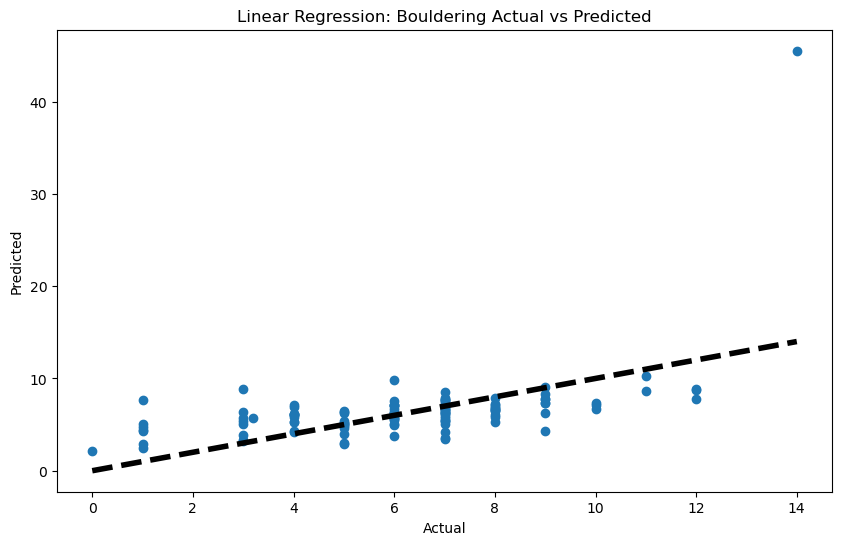

In [176]:
# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Bouldering Grade Forecasting - Linear Regression") as run:
    mlflow.set_tag("Description", "Linear Regression model to predict bouldering grades.")

    # step 1: Data Preparation for Linear Regression Bouldering Grade Forecasting
    X = data_filtered_bouldering[independent_vars_bouldering]
    y_boulder = data_filtered_bouldering['max_boulder_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # convert scaled arrays back to DataFrame
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    # step 3: Model Selection
    model = LinearRegression()

    # step 4: Model Training
    model.fit(X_train_scaled, y_train)

    # step 5: Model Evaluation
    y_pred = model.predict(X_test_scaled)
    y_train_pred = model.predict(X_train_scaled)
    
    # evaluate the model using evaluation metrics on test data
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # evaluate on training data
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    # log metrics to mlflow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mse_train", mse_train)
    mlflow.log_metric("mae_train", mae_train)
    mlflow.log_metric("r2_train", r2_train)
    mlflow.log_metric("mse_test", mse)
    mlflow.log_metric("mae_test", mae)
    mlflow.log_metric("r2_test", r2)

    # log model to mlflow
    mlflow.sklearn.log_model(model, "LinearRegressionModelBouldering")

    print(f"Training Data - Linear Regression Mean Squared Error: {mse_train}")
    print(f"Training Data - Linear Regression Mean Absolute Error: {mae_train}")
    print(f"Training Data - Linear Regression R-squared: {r2_train}")

    print(f"Testing Data - Linear Regression Mean Squared Error: {mse}")
    print(f"Testing Data - Linear Regression Mean Absolute Error: {mae}")
    print(f"Testing Data - Linear Regression R-squared: {r2}")

    # step 6: Model Fine-tuning (if necessary)

    # step 7: Model Deployment
    # Once we are satisfied with the model's performance, we can deploy it to make predictions on new data (e.g. using the user's input from above)
    new_data_scaled_bouldering = scaler.transform(new_data_bouldering)
    predicted_grade_numeric = model.predict(new_data_scaled_bouldering)
    predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_numeric[0]))
    print(f"Predicted Max Boulder Grade: {predicted_grade}")

    # plot the results of the model
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred) 
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Linear Regression: Bouldering Actual vs Predicted')

    plt.show()

**Linear Regression Model Results**

Mean Squared Error (MSE): This is an average of the square of the errors, or the differences between the true values and the predictions. The MSE for this linear regression model is 7.95, which means the square of the differences between the observed and predicted values averages to 3.5. A lower MSE indicates a better fit to the data. 

Mean Absolute Error (MAE): This is an average of the absolute differences between the true and predicted values. In this case, the MAE is 1.4, which is easier to interpret because it's in the same units as the original data. This means that on average, the predictions are about 1.4 units away from the actual values.

R-squared: R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. Normally, it ranges from 0 to 1, with 1 indicating a perfect fit. However, if the model is worse than a simple mean model, R-squared can be negative. In this case, R-squared is 0.37 which tells us that 37% of the variability in max bouldering grade can be explained by the model.

No active run.
Randomized search best score: 0.5149935940066379
Randomized search best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 8}
Cross-Validation Mean Squared Error: 3.0014082386134846
Cross-Validation MSE Standard Deviation: 0.138064544940271
Feature: strength_to_weight_pullup, Score: 0.14746
Feature: strength_to_weight_maxhang, Score: 0.31273
Feature: strength_to_weight_weightpull, Score: 0.15935
Feature: continuous, Score: 0.18492
Feature: exp, Score: 0.08014
Feature: days, Score: 0.11541
Training Data - Random Forest Mean Squared Error: 0.9387085657198719
Training Data - Random Forest Mean Absolute Error: 0.7878944993670787
Training Data - Random Forest R-squared: 0.8530418277043716
Testing Data - Random Forest Mean Squared Error: 3.7033064545678887
Testing Data - Random Forest Mean Absolute Error: 1.4386863542116843
Testing Data - Random Forest R-squared: 0.44831134575922627
Random Forest Predicted Max Boulder Grade: V10


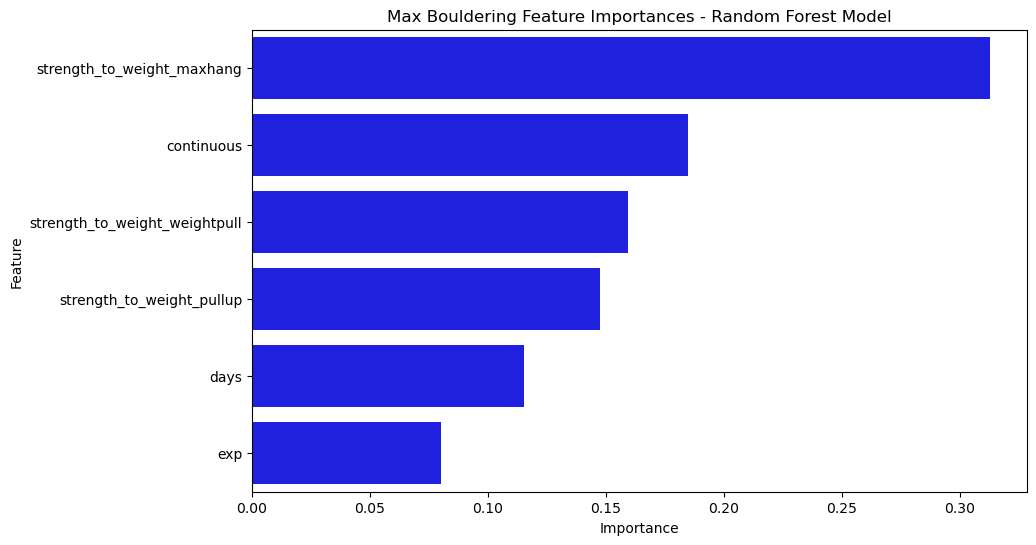

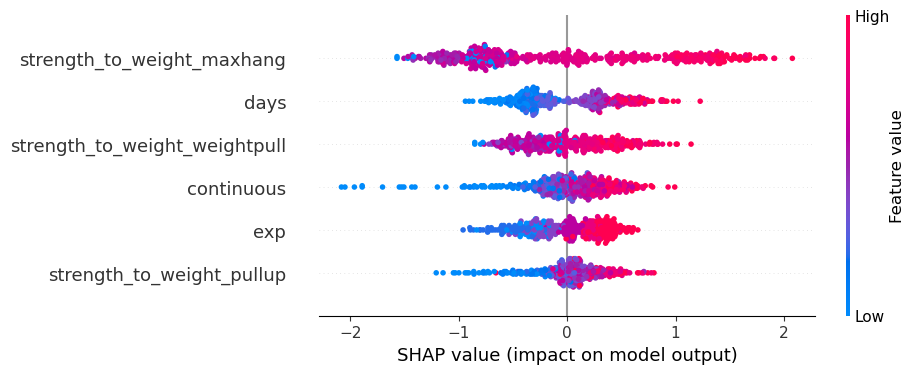

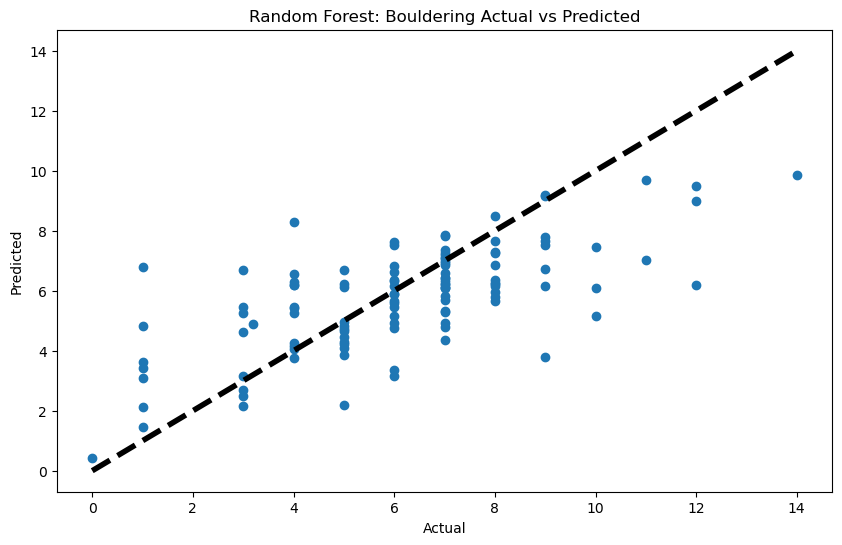

In [177]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")
    
with mlflow.start_run(run_name="Bouldering Grade Forecasting - Random Forest") as run:
    mlflow.set_tag("Description", "Random Forest model to predict bouldering grades.")
    
    # step 1: Data Preparation for Bouldering Grade Forecasting - Random Forest Regression
    X = data_filtered_bouldering[independent_vars_bouldering]
    y_boulder = data_filtered_bouldering['max_boulder_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # Step 3: Model Selection with Regularization
    model_rf = RandomForestRegressor(random_state=42, max_features='sqrt')

    # Define the parameter values that should be searched (you can keep the existing parameter grid)
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [None, 6, 8, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # No need for GridSearchCV, we'll use RandomizedSearchCV for hyperparameter tuning

    # Step 4: Cross-Validation and Hyperparameter Tuning
    from sklearn.model_selection import RandomizedSearchCV

    # Create a RandomizedSearchCV object
    random_search_rf = RandomizedSearchCV(
        model_rf, param_distributions=param_grid, n_iter=20, cv=5, random_state=42)

    # Fit the RandomizedSearchCV to the data (this performs cross-validation and hyperparameter tuning)
    random_search_rf.fit(X_train_scaled, y_train)

    # Examine the best model
    print(f"Randomized search best score: {random_search_rf.best_score_}")
    print(f"Randomized search best params: {random_search_rf.best_params_}")

    # Access the best model
    best_rf_model = random_search_rf.best_estimator_

    # Step 5: Model Evaluation
    # Perform cross-validation to evaluate the model
    cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

    # Convert the negative MSE scores to positive
    cv_mse_scores = -cv_scores

    # Calculate the mean and standard deviation of the cross-validation MSE scores
    mean_cv_mse = cv_mse_scores.mean()
    std_cv_mse = cv_mse_scores.std()

    # Print the cross-validation results
    print(f"Cross-Validation Mean Squared Error: {mean_cv_mse}")
    print(f"Cross-Validation MSE Standard Deviation: {std_cv_mse}")

    # step 5: Model Evaluation
    # make predictions on the testing dataset
    y_pred_rf = random_search_rf.predict(X_test_scaled)
    # make predictions on the training dataset
    y_train_pred_rf = random_search_rf.predict(X_train_scaled)

    # print the feature importance
    importance = random_search_rf.best_estimator_.feature_importances_
    for i, j in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (X.columns[i],j))
        
    # evaluate the model using evaluation metrics
    # test data
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    # training data
    mse_rf_train = mean_squared_error(y_train, y_train_pred_rf)
    mae_rf_train = mean_absolute_error(y_train, y_train_pred_rf)
    r2_rf_train = r2_score(y_train, y_train_pred_rf)


    # Log hyperparameters
    best_params = random_search_rf.best_params_
    mlflow.log_params(best_params)
    # Log metrics to mlflow
    mlflow.log_metric("mse", mse_rf)
    mlflow.log_metric("mae", mae_rf)
    mlflow.log_metric("r2", r2_rf)
    mlflow.log_metric("mse_train", mse_rf_train)
    mlflow.log_metric("mae_train", mae_rf_train)
    mlflow.log_metric("r2_train", r2_rf_train)
    mlflow.log_metric("mse_test", mse_rf)
    mlflow.log_metric("mae_test", mae_rf)
    mlflow.log_metric("r2_test", r2_rf)
    # Log feature importances
    for feature, importance in zip(X.columns, random_search_rf.best_estimator_.feature_importances_):
        mlflow.log_param(f"feature_importance_{feature}", importance)
    # Log model to mlflow
    mlflow.sklearn.log_model(random_search_rf.best_estimator_, "RandomForestModelBouldering")
    

    print(f"Training Data - Random Forest Mean Squared Error: {mse_rf_train}")
    print(f"Training Data - Random Forest Mean Absolute Error: {mae_rf_train}")
    print(f"Training Data - Random Forest R-squared: {r2_rf_train}")

    print(f"Testing Data - Random Forest Mean Squared Error: {mse_rf}")
    print(f"Testing Data - Random Forest Mean Absolute Error: {mae_rf}")
    print(f"Testing Data - Random Forest R-squared: {r2_rf}")

    # Predict with new data
    new_data_scaled = scaler.transform(new_data_bouldering)
    new_data_scaled_bouldering = scaler.transform(new_data_bouldering)
    predicted_grade_rf = random_search_rf.predict(new_data_scaled_bouldering)
    predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_rf[0]))
    print(f"Random Forest Predicted Max Boulder Grade: {predicted_grade}")

    # get feature importances for visualization
    importances = random_search_rf.best_estimator_.feature_importances_
    # create a dataframe for visualization
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    # create a bar plot for feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title('Max Bouldering Feature Importances - Random Forest Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    # plot feature importance using SHAP values
    explainer = shap.TreeExplainer(random_search_rf.best_estimator_, feature_names=X.columns)
    shap_values = explainer(X_train_scaled)
    shap.plots.beeswarm(shap_values)

    # plot actual vs predicted scatter
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_rf)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Random Forest: Bouldering Actual vs Predicted')
    plt.show()
    
# save the best model as a pkl file to use elsewhere
with open('best_model_rf_bouldering.pkl', 'wb') as f:
    pickle.dump(random_search_rf.best_estimator_, f)

# save the scaler as a pkl file to use elsewhere
with open('scaler_rf_bouldering.pkl', 'wb') as f:
    pickle.dump(scaler, f)


**Feature Importance Results**

Strength_to_weight_maxhang is the most important feature (with a score of 0.55) in predicting the output variable in the model. This means that changes in strength_to_weight_maxhang have the biggest effect on the model's predictions.

The second most important feature is strength_to_weight_pullup with a score of 0.11. It's followed by the number of days spent climbing outside (0.13)

So, in terms of predictive power for the model, the features rank as follows:

1. strength_to_weight_maxhang
2. strength_to_weight_pullup
3. days
4. strength_to_weight_weightpull


**SHAP Results**

As expected max hang ratio comes out on top having the potential to offer a +-3 V grade swing in the prediction, followed by days climbing outside and then strength_to_weight_weightpull. This is quite a large swing (+/-3) but at this point in time I'm not sure how to improve on this.

**Random Forest Model Results**

Mean Squared Error (MSE): In this case, the MSE for the Random Forest model is approximately 2.9 MSE is always non-negative, and a value of 0 would indicate a perfect fit to the data. The smaller the MSE, the better the model's performance.

Mean Absolute Error (MAE): The MAE of the Random Forest model is approximately 1.3.

R-squared (R^2): The R-squared of the  Random Forest model is approximately 0.52 which is okay, but could be better. There is some overfitting as the training data R^2 is 0.62.

Predicted Max Boulder Grade: This is the prediction output of the model for a specific input. In this case, the Random Forest model predicted a Max Boulder Grade of 'V5'.

In summary, based on these metrics, the Random Forest model is performing decently, with some room for improvement. The R-squared value could ideally be higher, as 0.52 indicates that only 52% of the variance in the target variable is being explained by the model. 

No active run.
Randomized search best score: 0.49609052686104355
Randomized search best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 2, 'learning_rate': 0.1}
Feature: strength_to_weight_pullup, Score: 0.07003
Feature: strength_to_weight_maxhang, Score: 0.54399
Feature: strength_to_weight_weightpull, Score: 0.07560
Feature: continuous, Score: 0.11144
Feature: exp, Score: 0.08287
Feature: days, Score: 0.11608
Training Data - Gradient Boosting Mean Squared Error: 1.9143667444535215
Training Data - Gradient Boosting Mean Absolute Error: 1.0996896046952553
Training Data - Gradient Boosting R-squared: 0.7002990617725158
Testing Data - Gradient Boosting Mean Squared Error: 3.47578546640353
Testing Data - Gradient Boosting Mean Absolute Error: 1.445389857784035
Testing Data - Gradient Boosting R-squared: 0.4822055830608951
Gradient Boosting Predicted Max Boulder Grade: V9


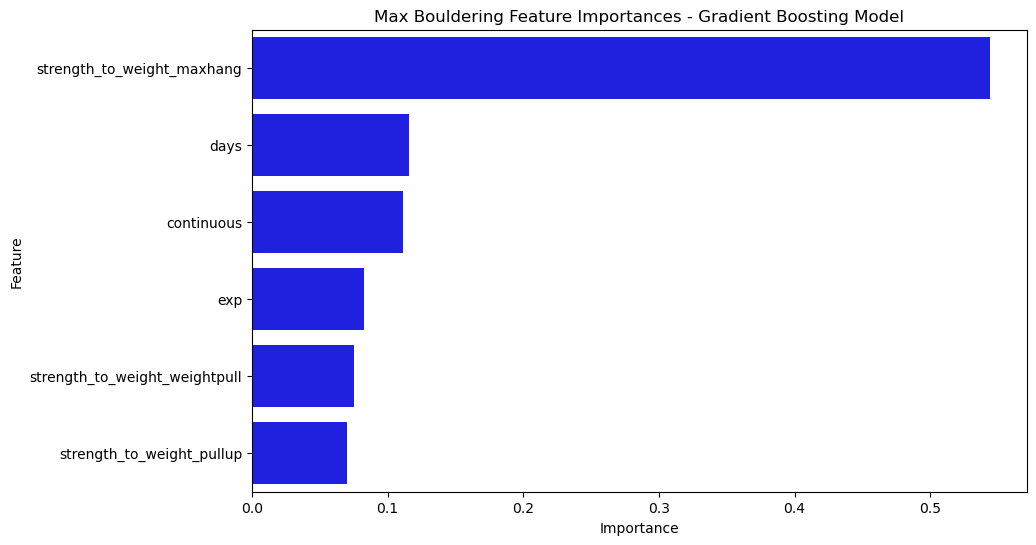

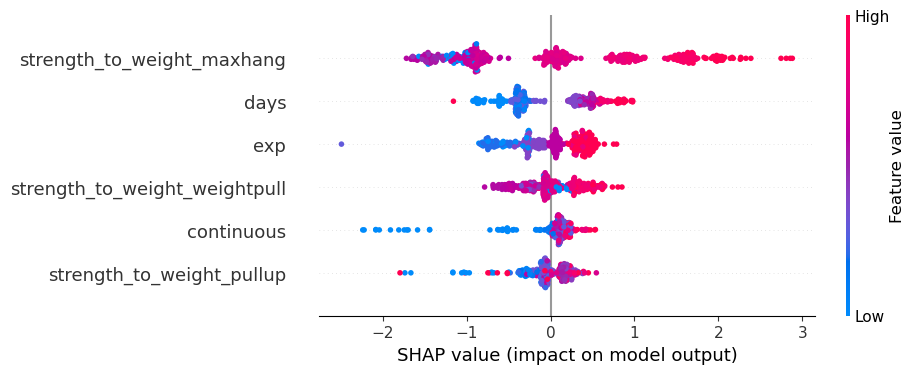

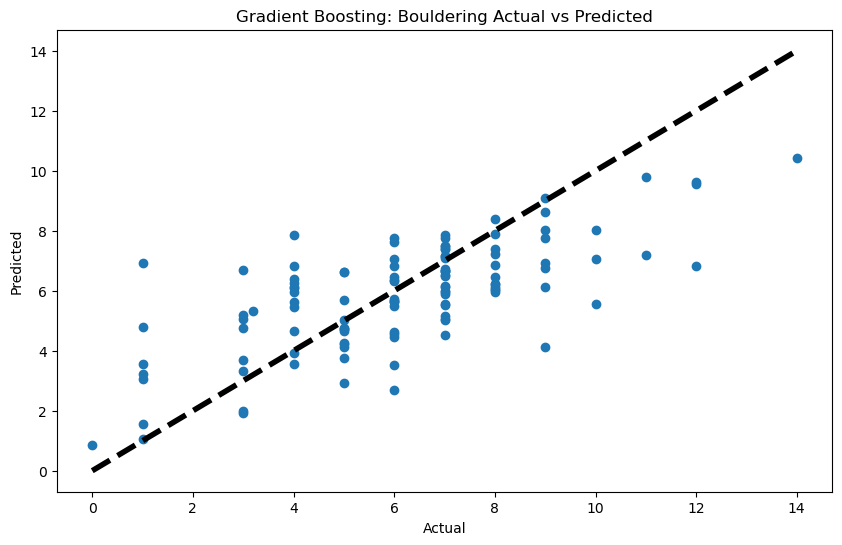

In [178]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Bouldering Grade Forecasting - Gradient Boosting") as run:
    mlflow.set_tag("Description", "Gradient Boosting model to predict bouldering grades.")

    # step 1: Data Preparation for Bouldering Grade Forecasting - Gradient Boosting Model
    X = data_filtered_bouldering[independent_vars_bouldering]
    y_boulder = data_filtered_bouldering['max_boulder_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # step 3: Model Selection with Randomized Search
    model_gb = GradientBoostingRegressor(random_state=42)

    # define the parameters grid
    param_grid_gb = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [None, 2, 4, 6],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 3]
    }

    # Create a RandomizedSearchCV object
    random_search_gb = RandomizedSearchCV(
        model_gb, param_distributions=param_grid_gb, n_iter=20, cv=5, random_state=42)

    # Fit the RandomizedSearchCV to the data (this performs cross-validation and hyperparameter tuning)
    random_search_gb.fit(X_train_scaled, y_train)

    # Examine the best model
    print(f"Randomized search best score: {random_search_gb.best_score_}")
    print(f"Randomized search best params: {random_search_gb.best_params_}")

    # Make the best model the new Gradient Boosting model
    model_gb = random_search_gb.best_estimator_

    # step 5: Model Evaluation
    # Make predictions on the testing dataset
    y_pred_gb = model_gb.predict(X_test_scaled)
    # Make predictions on the training dataset
    y_train_pred_gb = model_gb.predict(X_train_scaled)

    # Print the feature importance
    importance = model_gb.feature_importances_
    for i, j in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (X.columns[i], j))

    # Evaluate the model using evaluation metrics
    # Test data
    mse_gb = mean_squared_error(y_test, y_pred_gb)
    mae_gb = mean_absolute_error(y_test, y_pred_gb)
    r2_gb = r2_score(y_test, y_pred_gb)
    # Training data
    mse_gb_train = mean_squared_error(y_train, y_train_pred_gb)
    mae_gb_train = mean_absolute_error(y_train, y_train_pred_gb)
    r2_gb_train = r2_score(y_train, y_train_pred_gb)

    # Log hyperparameters
    best_params = random_search_gb.best_params_
    mlflow.log_params(best_params)
    # Log metrics to mlflow
    mlflow.log_metric("mse", mse_gb)
    mlflow.log_metric("mae", mae_gb)
    mlflow.log_metric("r2", r2_gb)
    mlflow.log_metric("mse_train", mse_gb_train)
    mlflow.log_metric("mae_train", mae_gb_train)
    mlflow.log_metric("r2_train", r2_gb_train)
    mlflow.log_metric("mse_test", mse_gb)
    mlflow.log_metric("mae_test", mae_gb)
    mlflow.log_metric("r2_test", r2_gb)
    # Log feature importances
    for feature, importance in zip(X.columns, model_gb.feature_importances_):
        mlflow.log_param(f"feature_importance_{feature}", importance)
    # Log model to mlflow
    mlflow.sklearn.log_model(model_gb, "GradientBoostingModelBouldering")

    print(f"Training Data - Gradient Boosting Mean Squared Error: {mse_gb_train}")
    print(f"Training Data - Gradient Boosting Mean Absolute Error: {mae_gb_train}")
    print(f"Training Data - Gradient Boosting R-squared: {r2_gb_train}")

    print(f"Testing Data - Gradient Boosting Mean Squared Error: {mse_gb}")
    print(f"Testing Data - Gradient Boosting Mean Absolute Error: {mae_gb}")
    print(f"Testing Data - Gradient Boosting R-squared: {r2_gb}")

    # Predict with new data
    new_data_scaled_bouldering = scaler.transform(new_data_bouldering)
    predicted_grade_gb = model_gb.predict(new_data_scaled_bouldering)
    predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_gb[0]))
    print(f"Gradient Boosting Predicted Max Boulder Grade: {predicted_grade}")

    # Get feature importances for visualization
    importances = model_gb.feature_importances_
    # Create a dataframe for visualization of feature importance
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title('Max Bouldering Feature Importances - Gradient Boosting Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    # Plot feature importance using SHAP values
    explainer = shap.Explainer(model_gb, feature_names=X.columns)
    shap_values = explainer(X_train_scaled)
    shap.plots.beeswarm(shap_values)

    # Plot scatter plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_gb)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Gradient Boosting: Bouldering Actual vs Predicted')
    plt.show()

# Save the best model
with open('best_model_gb_bouldering.pkl', 'wb') as f:
    pickle.dump(model_gb, f)

# Save the scaler
with open('scaler_gb_bouldering.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Feature Importance Results**

Strength_to_weight_maxhang is the most important feature (with a score of 0.49) in predicting the output variable in the model. This means that changes in strength_to_weight_maxhang have the biggest effect on the model's predictions.

The second most important feature is strength_to_weight_pullup followed by days climbing outside, and then strength_to_weight_weightpull.

So, in terms of predictive power for the model, the features rank as follows:

1. strength_to_weight_maxhang
2. strength_to_weight_pull
3. strength_to_weight_weightpull
4. days climbing outside

These results are slightly different from the RF model in that number 3 and 4 are swapped. This still leaves the max hangs to bodyweight ratio at the top.

**SHAP Results**

Again as expected the maxhangs ratio comes out on top having the potential to offer a +-2 V grade swing in the prediction, followed by days and then weighted pullups ratio. 

**Gradient Boosting Model Results**

Mean Squared Error (MSE): The MSE for the Gradient Boosting model is approximately 2.9. 

Mean Absolute Error (MAE): The MAE for the Gradient Boosting model is approximately 1.3. Both MSE and MAE are almost identical to the RF model results.

R-squared (R^2): The R-squared for the Gradient Boosting model is approximately 0.53. This value indicates that the model explains about 53% of the variance in the target variable. 

In summary, the Gradient Boosting model performs slightly better than the Random Forest model, based on these metrics. The R-squared value is slightly higher, indicating that it can explain a bit more variance in the target variable. The MAE and MSE are also slightly lower, indicating fewer prediction errors.

The predicted grade is actually slightly higher in this case, V6 instead of V5.

No active run.
Training Data - Linear Regression Mean Squared Error: 7.176100462648008
Training Data - Linear Regression Mean Absolute Error: 2.0464213235797213
Training Data - Linear Regression R-squared: 0.43055398567064596
Testing Data - Linear Regression Mean Squared Error: 14.704123125571373
Testing Data - Linear Regression Mean Absolute Error: 2.3649261279527356
Testing Data - Linear Regression R-squared: 0.09426321983814401
Predicted Max Sport Grade: 7b


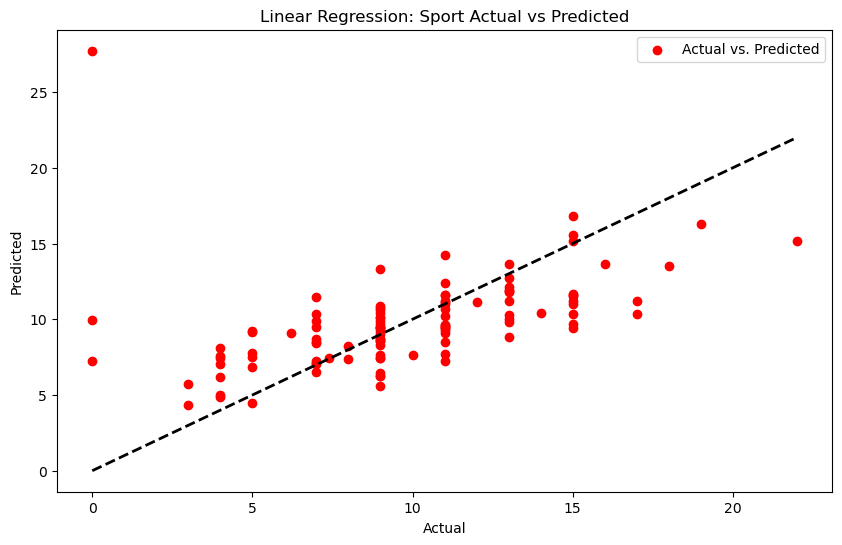

In [179]:
# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")
    
with mlflow.start_run(run_name="Sport Grade Forecasting - Linear Regression") as run:
    mlflow.set_tag("Description", "Linear Regression model to predict sport grades.")
    

    # step 1: Data Preparation for Linear Regression Sport Grade Forecasting
    X = data_filtered_sport[independent_vars_sport]
    y_sport = data_filtered_sport['max_sport_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # step 3: Model Selection
    # choose the machine learning algorithm
    model = LinearRegression()

    # step 4: Model Training
    model.fit(X_train_scaled, y_train)

    # step 5: Model Evaluation
    y_pred = model.predict(X_test_scaled)
    y_train_pred = model.predict(X_train_scaled)
    
    # evaluate the model using evaluation metrics on test data
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # evaluate on training data
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    
    # log metrics to mlflow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    # log metrics to mlflow
    mlflow.log_metric("mse_train", mse_train)
    mlflow.log_metric("mae_train", mae_train)
    mlflow.log_metric("r2_train", r2_train)
    mlflow.log_metric("mse_test", mse)
    mlflow.log_metric("mae_test", mae)
    mlflow.log_metric("r2_test", r2)

    print(f"Training Data - Linear Regression Mean Squared Error: {mse_train}")
    print(f"Training Data - Linear Regression Mean Absolute Error: {mae_train}")
    print(f"Training Data - Linear Regression R-squared: {r2_train}")

    print(f"Testing Data - Linear Regression Mean Squared Error: {mse}")
    print(f"Testing Data - Linear Regression Mean Absolute Error: {mae}")
    print(f"Testing Data - Linear Regression R-squared: {r2}")
    
    # log model
    mlflow.sklearn.log_model(model, "LinearRegressionModelSport")

    # step 6: Model Fine-tuning (if necessary)

    # step 7: Model Deployment

    # example prediction
    new_data_scaled_sport = scaler.transform(new_data_sport)
    predicted_grade = model.predict(new_data_scaled_sport)
    predicted_grade = convert_numeric_to_f_grade(float(predicted_grade[0]))
    print(f"Predicted Max Sport Grade: {predicted_grade}")

    # plotting for Linear Regression
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='r', label='Actual vs. Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.legend()
    plt.title('Linear Regression: Sport Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()


Linear regression results for sport climbing are performing worse than what they were for bouldering with an R^2 of 0.35. This is our most basic model, so let's see if we can improve on this score with the RF and GB models.

No active run.
Best parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 466}
Best score:  0.45988526868793933
Feature: strength_to_weight_pullup, Score: 0.10111
Feature: strength_to_weight_maxhang, Score: 0.07982
Feature: strength_to_weight_weightpull, Score: 0.08575
Feature: continuous, Score: 0.09668
Feature: repeaters1, Score: 0.27483
Feature: exp, Score: 0.11046
Feature: days, Score: 0.25135
Training Data - Random Forest Mean Squared Error: 1.338547396447242
Training Data - Random Forest Mean Absolute Error: 0.8963692952946056
Training Data - Random Forest R-squared: 0.8937820779035541
Testing Data - Random Forest Mean Squared Error: 9.708681445841462
Testing Data - Random Forest Mean Absolute Error: 2.1761412388027632
Testing Data - Random Forest R-squared: 0.40196978784262594
Random Forest Predicted Predicted Max Sport Grade: 7a+


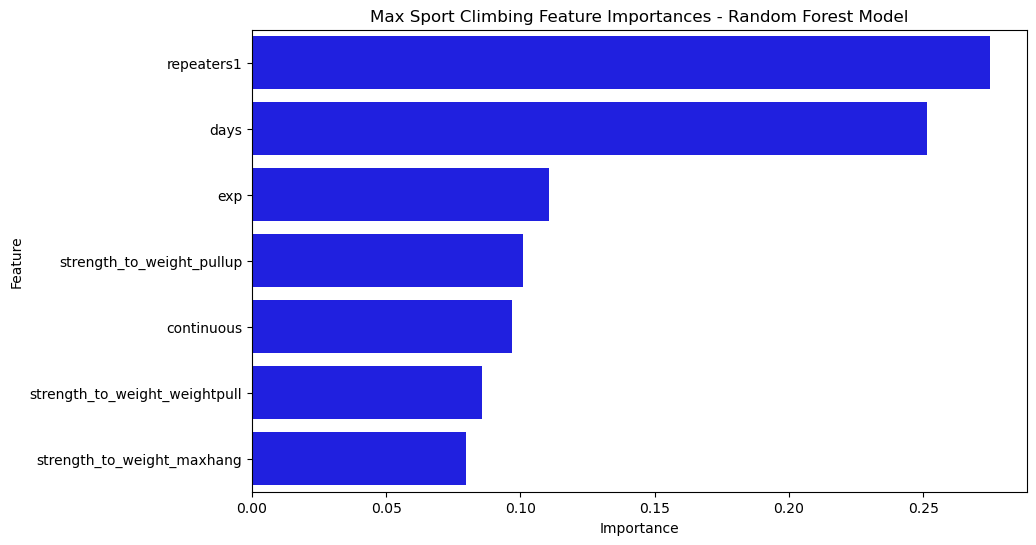

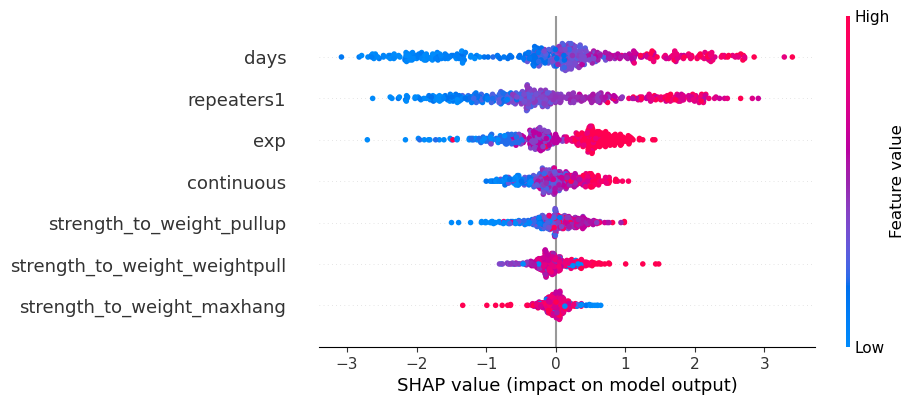

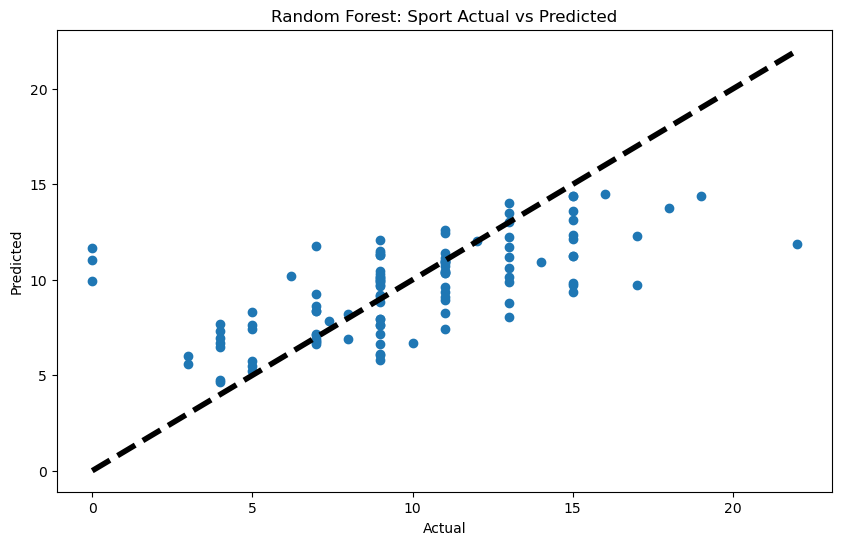

In [180]:
# Import RandomizedSearchCV and randint
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Sport Grade Forecasting - Random Forest") as run:
    mlflow.set_tag("Description", "Random Forest model to predict sport grades.")
    
    # step 1: Data Preparation for RFR Sport Grade Forecasting
    X = data_filtered_sport[independent_vars_sport]
    y_sport = data_filtered_sport['max_sport_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # step 3: Model Selection

    # define the parameter grid
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': [None, 6, 8, 10],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5)
    }

    # initialize the Random Forest model
    model_rf = RandomForestRegressor(random_state=42)

    # initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(model_rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

    # step 4: Model Training
    random_search.fit(X_train_scaled, y_train)

    # make the best model the new random forest model
    model_rf = random_search.best_estimator_

    # get the best parameters and best score
    print("Best parameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)

    # log best parameters from Randomized Search
    best_params = random_search.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)
        
        
    # print the feature importance
    importance = model_rf.feature_importances_
    for i, j in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (X.columns[i],j))

    # step 5: Model Evaluation
    y_pred_rf = model_rf.predict(X_test_scaled)
    y_train_pred_rf = model_rf.predict(X_train_scaled)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    # evaluate the model on training data using evaluation metrics
    mse_rf_train = mean_squared_error(y_train, y_train_pred_rf)
    mae_rf_train = mean_absolute_error(y_train, y_train_pred_rf)
    r2_rf_train = r2_score(y_train, y_train_pred_rf)

    # log metrics to mlflow
    mlflow.log_metric("mse", mse_rf)
    mlflow.log_metric("mae", mae_rf)
    mlflow.log_metric("r2", r2_rf)
    mlflow.log_metric("mse_train", mse_rf_train)
    mlflow.log_metric("mae_train", mae_rf_train)
    mlflow.log_metric("r2_train", r2_rf_train)
    mlflow.log_metric("mse_test", mse_rf)
    mlflow.log_metric("mae_test", mae_rf)
    mlflow.log_metric("r2_test", r2_rf)
    # Log feature importances
    for feature, importance in zip(X.columns, model_rf.feature_importances_):
        mlflow.log_param(f"feature_importance_{feature}", importance)
        
    # log model
    mlflow.sklearn.log_model(model_rf, "RandomForestModelSport")
    
    print(f"Training Data - Random Forest Mean Squared Error: {mse_rf_train}")
    print(f"Training Data - Random Forest Mean Absolute Error: {mae_rf_train}")
    print(f"Training Data - Random Forest R-squared: {r2_rf_train}")

    print(f"Testing Data - Random Forest Mean Squared Error: {mse_rf}")
    print(f"Testing Data - Random Forest Mean Absolute Error: {mae_rf}")
    print(f"Testing Data - Random Forest R-squared: {r2_rf}")

    
    # Predict with new data
    new_data_scaled_sport = scaler.transform(new_data_sport)
    predicted_grade_rf = model_rf.predict(new_data_scaled_sport)
    predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_rf[0]))
    print(f"Random Forest Predicted Predicted Max Sport Grade: {predicted_grade}")


    # create a dataframe for visualization
    importances = model_rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title('Max Sport Climbing Feature Importances - Random Forest Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    # plot feature importance using SHAP values
    explainer = shap.Explainer(model_rf,feature_names=X.columns)
    shap_values = explainer(X_train_scaled)
    shap.plots.beeswarm(shap_values)

    # plot scatter plot of actuals vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_rf)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Random Forest: Sport Actual vs Predicted')
    plt.show()

# save the best model
with open('best_model_rf_sport.pkl', 'wb') as f:
    pickle.dump(model_rf, f)

# save the scaler
with open('scaler_rf_sport.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Feature Importance Results**

What's interesting with the below results is how different they are to the bouldering results. Max hang ratio seems to have the least influential role to play, while weighted pullups ratio and continuous play a bigger role. We could make an assumption and say that being able to hang on to small edges for longer is more beneficial in sport climbing, as is being able to pull more than your bodyweight for longer periods of time (thus weighted pullups to weight ratio also being important).

Days climbing outside is first (0.24) followed by repeaters with a score of 0.21, continuous (0.14) and then strength_to_weight_weightpull (0.11).

So, in terms of predictive power for the model, the features rank as follows:

1. days climbing outside
2. repeaters1
3. continuous
4. strength_to_weight_weightpull


**SHAP Results**

Generally the same pattern as the feature importance results with number of days outside giving a -3/+2 swing in max sport grade. Interestingly enough, total climbing experience sneaks into 3rd place here with a -2/+2 swing.

**Random Forest Model Results**

Mean Squared Error (MSE): An MSE of 8.5 means that, on average, the squared difference between the predicted and actual values is 8.5. The lower this value is, the better the model's performance.

Mean Absolute Error (MAE): The MAE for the model is 2.13, which means that, on average, the predictions are off by around 2.13 units.

R-squared: An R-squared of 100 percent indicates that all changes in the dependent variable are completely explained by changes in the independent variable(s). This model's R-squared is approximately 0.48, indicating that around 48% of the variability in the 'max_sport_numeric' is accounted for by the features in the model. There is some overfitting taking place here as the R^2 for the training data is 0.63 compared to the testing data (0.48).

No active run.
Best parameters:  {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 483}
Best score:  0.46262189430041156
Feature: strength_to_weight_pullup, Score: 0.08458
Feature: strength_to_weight_maxhang, Score: 0.01208
Feature: strength_to_weight_weightpull, Score: 0.04998
Feature: continuous, Score: 0.07699
Feature: repeaters1, Score: 0.30603
Feature: exp, Score: 0.18066
Feature: days, Score: 0.28968
Training Data - Gradient Boosting Mean Squared Error: 4.623915067692389
Training Data - Gradient Boosting Mean Absolute Error: 1.6748363608427301
Training Data - Gradient Boosting R-squared: 0.6330778784940166
Testing Data - Gradient Boosting Mean Squared Error: 9.096489075613176
Testing Data - Gradient Boosting Mean Absolute Error: 2.1743250276270287
Testing Data - Gradient Boosting R-squared: 0.43967928887951113
Gradient Boosted Predicted Predicted Max Sport Grade: 6b+


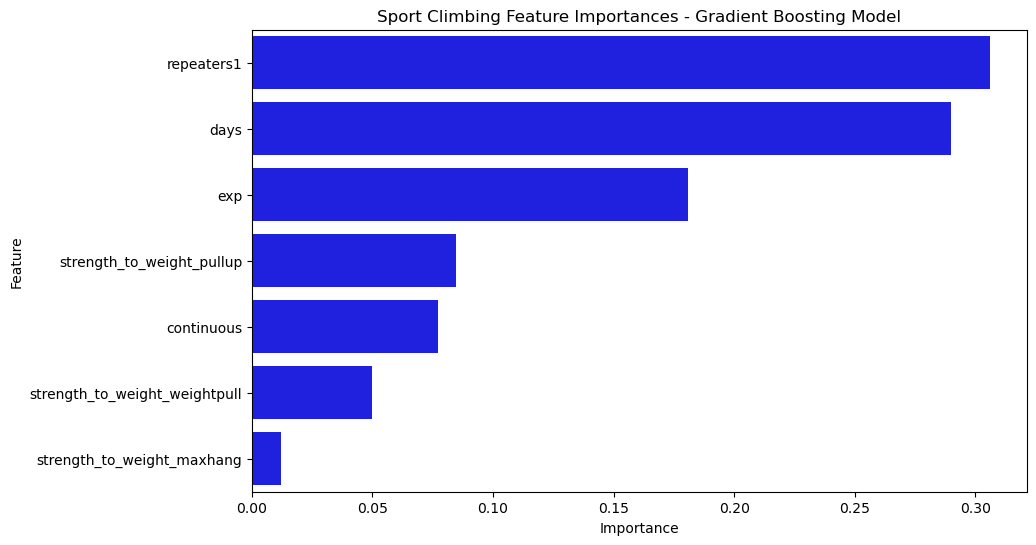

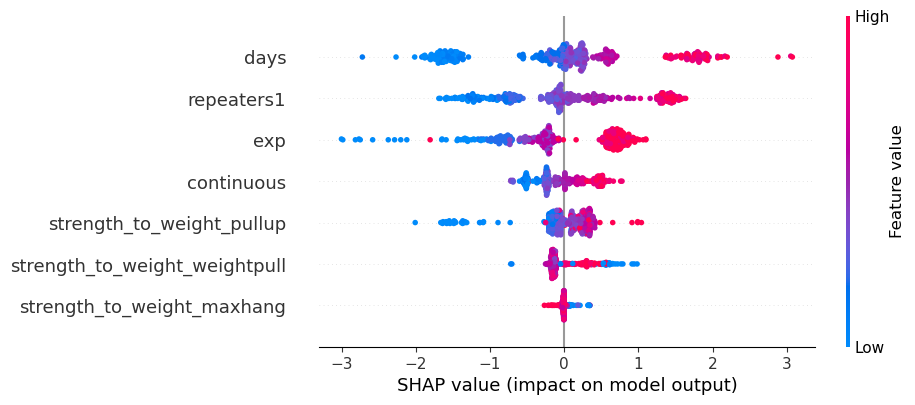

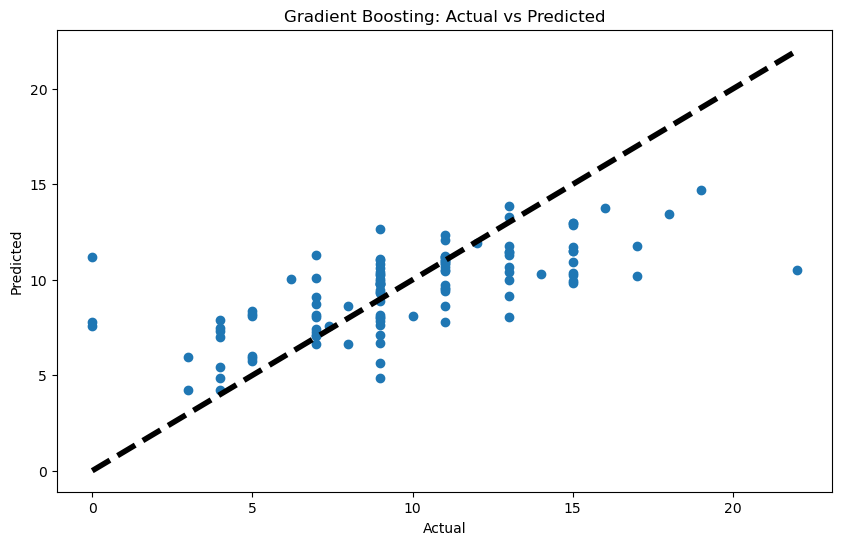

In [181]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Sport Grade Forecasting - Gradient Boosting") as run:
    mlflow.set_tag("Description", "Gradient Boosting model to predict sport grades.")
    
    # step 1: Data Preparation for Sport Grade Forecasting
    X = data_filtered_sport[independent_vars_sport]
    y_sport = data_filtered_sport['max_sport_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # step 3: Model Selection with Randomized Search
    model_gb = GradientBoostingRegressor(random_state=42)
    param_dist = {
        'n_estimators': randint(100, 500),
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [None, 2, 4, 6],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5)
    }
    
    # Initialize RandomizedSearchCV
    random_search_gb = RandomizedSearchCV(model_gb, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

    # step 4: Model Training
    random_search_gb.fit(X_train_scaled, y_train)

    # log best parameters from Randomized Search
    best_params = random_search_gb.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    # print the best parameters and the best score
    print("Best parameters: ", random_search_gb.best_params_)
    print("Best score: ", random_search_gb.best_score_)

    # make the best model the new Gradient Boosting model
    model_gb = random_search_gb.best_estimator_

    # print the feature importance
    importance = model_gb.feature_importances_
    for i, j in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (X.columns[i], j))

    # get feature importances for visualization
    importances = model_gb.feature_importances_

    # create a dataframe for visualization
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # step 5: Model Evaluation
    # make predictions on the testing dataset
    y_pred_gb = model_gb.predict(X_test_scaled)
    # make predictions on the training dataset
    y_train_pred_gb = model_gb.predict(X_train_scaled)

    # evaluate the model on test data using evaluation metrics
    mse_gb = mean_squared_error(y_test, y_pred_gb)
    mae_gb = mean_absolute_error(y_test, y_pred_gb)
    r2_gb = r2_score(y_test, y_pred_gb)

    # evaluate the model on training data using evaluation metrics
    mse_gb_train = mean_squared_error(y_train, y_train_pred_gb)
    mae_gb_train = mean_absolute_error(y_train, y_train_pred_gb)
    r2_gb_train = r2_score(y_train, y_train_pred_gb)

    # log metrics to mlflow
    mlflow.log_metric("mse", mse_gb)
    mlflow.log_metric("mae", mae_gb)
    mlflow.log_metric("r2", r2_gb)
    mlflow.log_metric("mse_train", mse_gb_train)
    mlflow.log_metric("mae_train", mae_gb_train)
    mlflow.log_metric("r2_train", r2_gb_train)
    mlflow.log_metric("mse_test", mse_gb)
    mlflow.log_metric("mae_test", mae_gb)
    mlflow.log_metric("r2_test", r2_gb)
    # Log feature importances
    for feature, importance in zip(X.columns, model_gb.feature_importances_):
        mlflow.log_param(f"feature_importance_{feature}", importance)
    # log model
    mlflow.sklearn.log_model(random_search_gb.best_estimator_, "GradientBoostingModelSport")

        
    print(f"Training Data - Gradient Boosting Mean Squared Error: {mse_gb_train}")
    print(f"Training Data - Gradient Boosting Mean Absolute Error: {mae_gb_train}")
    print(f"Training Data - Gradient Boosting R-squared: {r2_gb_train}")

    print(f"Testing Data - Gradient Boosting Mean Squared Error: {mse_gb}")
    print(f"Testing Data - Gradient Boosting Mean Absolute Error: {mae_gb}")
    print(f"Testing Data - Gradient Boosting R-squared: {r2_gb}")


    # predict with new data
    new_data_scaled_sport = scaler.transform(new_data_sport)
    predicted_grade = model_gb.predict(new_data_scaled_sport)
    predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_gb[0]))
    print(f"Gradient Boosted Predicted Predicted Max Sport Grade: {predicted_grade}")


    # Create a bar plot for feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title('Sport Climbing Feature Importances - Gradient Boosting Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    # plot feature importance using SHAP values
    explainer = shap.Explainer(model_gb,feature_names=X.columns)
    shap_values = explainer(X_train_scaled)
    shap.plots.beeswarm(shap_values)

    # scatter plot for actuals vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_gb)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Gradient Boosting: Actual vs Predicted')
    plt.show()

# save the best model
with open('best_model_gb_sport.pkl', 'wb') as f:
    pickle.dump(model_gb, f)

# save the scaler
with open('scaler_gb_sport.pkl', 'wb') as f:
    pickle.dump(scaler, f)


Days climbing outside is first (0.23) followed by experience (0.20), repeaters with a score of 0.19, and then continuous (0.13). Any actual strength metrics are lower e.g. strength_to_weight_weightpull (0.10).

So, in terms of predictive power for the model, the features rank as follows:

1. days climbing outside
2. total climbing experience
3. repeaters
4. continuous


**SHAP Results**

Generally the same pattern as the feature importance results with number of days outside giving a -3/+2 swing in max sport grade. 

**Random Forest Model Results**

Mean Squared Error (MSE): An MSE of 9.5 tells us that this model is performing slightly worse than the RF model (8.5)

Mean Absolute Error (MAE): The MAE for the model is 2.3, which means that, on average, the predictions are off by around 2.3 units. The RF model had similar results with 2.13.

R-squared: This model's R-squared is approximately 0.42, indicating that around 42% of the variability in the 'max_sport_numeric' is accounted for by the features in the model. There is some overfitting taking place here as the R^2 for the training data is 0.50, but the difference between training and testing is much lower than for the RF model.

![Rise of the sleepwalker](https://cdn.shopify.com/s/files/1/1554/2851/articles/sleepwalker-vid_e353c25c-7fdb-45ae-8bff-5f17eb8dad7c_1600x.jpg?v=1624463336)

**Final Thoughts**

Based on the above it's clear to see there are differences between what makes a strong boulderer and a strong sport climber, although there is definitely overlap between the two. The below overalls are based on the model with the lowest R^2.

Overall for bouldering, the order of priority seems to be:

1. strength_to_weight_maxhang
2. strength_to_weight_pull
3. strength_to_weight_weightpull
4. days climbing outside

This seems like a reasonable outcome given the raw strength and power needed for bouldering in the upper grades, with spending time outside also being an important factors. It's generally common knowledge that time spent climbing outside can significantly contritube to getting stronger and climbing harder grades. This might also account for the fact that more time spent outside means more time for projecting routes.


Overall for sport climbing, the order of priority seems to be:

1. days climbing outside
2. repeaters1
3. continuous
4. strength_to_weight_weightpull

However I think it's worth noting that the Gradient Boosting model also included total climbing experience in the top 4 results.

1. days climbing outside
2. total climbing experience
3. repeaters
4. continuous

The top performing variable is still the same, and repeaters and continuous are still important. If we look at these together, it looks like pure endurance metrics and actual time spent climbing on real rock contributes to higher sport climbing grades. I would say that the true results are a combination of the RF and GB models.


**Further thoughts**

I also think it might be worth re-running the sport climbing and bouldering models using other variables, maybe even running them with all the features to see if the results are much different.

Hope that was interesting, any thoughts/feedback/improvements you would make let me know!

In [182]:
import numpy
import pandas
import matplotlib
import seaborn
import scipy
import sklearn
import statsmodels
import shap
import mlflow
import pickle
import streamlit
import requests
import secrets

print("NumPy version:", numpy.__version__)
print("Pandas version:", pandas.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", seaborn.__version__)
print("SciPy version:", scipy.__version__)
print("Scikit-Learn version:", sklearn.__version__)
print("Statsmodels version:", statsmodels.__version__)
print("SHAP version:", shap.__version__)
print("MLflow version:", mlflow.__version__)
print("Streamlit version:", streamlit.__version__)
print("Requests version:", requests.__version__)
print("Pymongo version:", pymongo.__version__)

# Note: pickle is a standard library module, so it doesn't have a __version__ attribute


NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.8.0
Seaborn version: 0.12.2
SciPy version: 1.11.3
Scikit-Learn version: 1.3.1
Statsmodels version: 0.14.0
SHAP version: 0.43.0
MLflow version: 2.6.0
Streamlit version: 1.27.2
Requests version: 2.31.0
Pymongo version: 3.12.0
